# Tennisanalyse Datensatz Baden
In diesem Notebook analysieren wir die Daten, die mit der Zed 2 Kamera von Stereolabs aufgenommen wurden. Das Spiel wurde im Bareggcenter Baden aufgenommen.

In [401]:
#Importieren der benötigten Bibliotheken
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

from datetime import datetime

from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from hmmlearn import hmm

## Einleitung
Zur verfügung der Analyse haben wir zwei Dataframes. Ein Dataframe mit den gelabelten Daten die von uns mit der Aufnahme erzeugt wurden und ein Dataframe mit den Daten die von der Kamera erzeugt wurden.

In [313]:
#Einlesen der Dataframes 
df_cam = pd.read_csv("../Dataframe/df_detected_objects_game.csv")
df_labels = pd.read_csv("../Dataframe/tennis_labels_v2.csv", sep=";")

### Beschreibung Kamera Dataframe

In [314]:
df_cam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42571 entries, 0 to 42570
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frame           42571 non-null  int64  
 1   object_id       42571 non-null  int64  
 2   object_label    42571 non-null  object 
 3   confidence      42571 non-null  float64
 4   tracking_state  42571 non-null  object 
 5   x               42565 non-null  float64
 6   y               42565 non-null  float64
 7   z               42565 non-null  float64
 8   vx              42565 non-null  float64
 9   xy              42565 non-null  float64
 10  vz              42565 non-null  float64
 11  width           42571 non-null  float64
 12  height          42571 non-null  float64
 13  length          42571 non-null  float64
 14  head_x          0 non-null      float64
 15  head_y          0 non-null      float64
 16  head_z          0 non-null      float64
dtypes: float64(13), int64(2), objec

Die Kamera gibt folgende Daten aus: 
- frame: Frame Nummer
- object_id: ID der Person die erkennt wurde
- object_label: Label welches Objekt erkannt wurde
- confidence: Wahrscheinlichkeit wie sicher die Kamera ist, dass das Objekt erkannt wurde
- tracking_state: Status der Erkennung
- x: x-Koordinate des Objekts
- y: y-Koordinate des Objekts
- z: z-Koordinate des Objekts
- vx: Geschwindigkeit in x-Richtung
- xy: Geschwindigkeit in y-Richtung
- vz: Geschwindigkeit in z-Richtung
- width: Breite des Objekts
- height: Höhe des Objekts
- length: Länge des Objekts
- head_x: x-Koordinate des Kopfs
- head_y: y-Koordinate des Kopfs
- head_z: z-Koordinate des Kopfs

Insgesamt stehen uns 42571 Observationen mit 17 Features für die Analyse zur Verfügung.

### Beschreibung Label Dataframe

In [315]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Frame       169 non-null    int64  
 1   Status      64 non-null     object 
 2   Schlag _p1  75 non-null     object 
 3   Schlag _p2  62 non-null     object 
 4   Satz        3 non-null      float64
 5   Fehler_p1   22 non-null     object 
 6   Fehler_p2   10 non-null     object 
dtypes: float64(1), int64(1), object(5)
memory usage: 9.4+ KB


In [316]:
df_labels.rename(columns={"Schlag _p1": "Schlag_p1", "Schlag _p2": "Schlag_p2"}, inplace=True)

Die gelabelten Daten enthalten folgende Informationen:
- Frame: Frame Nummer wo ein oder mehrere Labels gesetzt wurde
- Status: Spiel Status (Aktiv oder Inaktiv)
- Schlag Spieler 1: Schlag des Spielers 1 (Anschlag, Fronthand, Backhand)
- Schlag Spieler 2: Schlag des Spielers 2 (Anschlag, Fronthand, Backhand)
- Satz: Satz Nummer
- Fehler_p1: Fehler des Spielers 1 (Netz, Out, Doppelfehler, Anschlagfehler)
- Fehler_p2: Fehler des Spielers 2 (Netz, Out, Doppelfehler, Anschlagfehler)

Insgesamt sind 169 Observationen vorhanden mit 7 Features.

# Hilfe Funktionen

In diesem Abschnitt sind alle Funktion die wird benötigen um die Daten zu wranglen und zu analysieren.

### Basis Transformation

In [317]:
def tennisfeld(r, P1, P2, P3):
    # P1, P2, P3 sind Kalibrierungspunkte
    # r ist der Punkt der transformiert werden soll
    # P1 Linke Ecke an der Grundlinie X Seitenlinie Einzelfeld
    # P2 Rechte Ecke an der Grundlinie X Seitenlinie Einzelfeld
    # P3 Mittelpunkt am Netz
    r1 = P2 - P1
    r3 = P3 - 0.5*(P1 + P2)
    # Basisvektoren
    r1u = r1 / np.sqrt(np.dot(r1, r1))
    r3u = r3 / np.sqrt(np.dot(r3, r3))
    r2u = np.cross(r1u, r3u)
    # Translation
    T0 = P3
    # Rotation
    M1 = np.c_[r1u, r2u, r3u]
    M1_inv = np.linalg.inv(M1)
    # Abbildung
    return np.inner(M1_inv, (r - T0))


### Tennisfeld zeichnen

In [318]:
def drawTennisField():
    plt.plot([4.11, 4.11], [-11.89, 11.89], 'k', lw=2) # Single sideline rechts
    plt.plot([5.48, 5.48], [-11.89, 11.89], 'k', lw=2) # Double sideline rechts
    plt.plot([-4.11, -4.11], [-11.89, 11.89], 'k', lw=2) # Single sideline links
    plt.plot([-5.48, -5.48], [-11.89, 11.89], 'k', lw=2) # Double sideline links
    plt.plot([0, 0], [-6.40, 6.40], 'k', lw=2) # Center Service Line
    plt.plot([-5.48, 5.48], [0, 0], 'k', lw=2) # Net
    plt.plot([-5.48, 5.48], [11.89, 11.89], 'k', lw=2) # Baseline oben
    plt.plot([-5.48, 5.48], [-11.89, -11.89], 'k', lw=2) # Baseline unten
    plt.plot([-4.11, 4.11], [-6.40, -6.40], 'k', lw=2) # Service Line unten
    plt.plot([-4.11, 4.11], [6.40, 6.40], 'k', lw=2) # Service Line oben

### Zonen auf dem Feld

In [319]:
def zonen(y):
    # y ist die Länge entlang der Seitenlinie
    abs_y = abs(y)
    if 6.4 > abs_y:  # Vom Netz bis zur Aufschlaglinie
        return "Sehr Offensiv"
    elif 9 > abs_y:  #Bis fast zur Grundlinie
        return "Offensiv"
    elif 12.1 > abs_y:  # Etwas hinter der Grundlinie
        return "Neutral"
    else:  # Deutlich hinter der Grundlinie
        return "Defensiv"


### Position auf dem Feld

In [320]:
def position(x):
    # x ist die Länge entlang der Grundlinie
    def_grenze = 1.5
    if x > def_grenze:
        return "Rechts"
    elif x < -def_grenze:
        return "Links"
    else:
        return "Mitte"


### Winkelberechnung

In [321]:
def calculate_angle(row):
    dx = row['new_x_Player2'] - row['new_x_Player1']
    dz = row['new_z_Player2'] - row['new_z_Player1']
    angle = np.degrees(np.arctan2(dz, dx))
    return angle

## Datawrangling

Das Datawrangling beschränkt sich grössten Teils auf den Datensatz der Kamera, da in dem Gelabelten Datensatz die Fehler sehr gering sein sollten.

### Suche nach auffälligen Werten

In [322]:
df_cam.describe(include="all")

,frame,object_id,object_label,confidence,tracking_state,x,y,z,vx,xy,vz,width,height,length,head_x,head_y,head_z
count,42571.000000,42571.000000,42571,42571.000000,42571,42565.000000,42565.000000,42565.000000,42565.000000,42565.000000,42565.000000,42571.000000,42571.000000,42571.000000,0.0,0.0,0.0
unique,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Person,NaN,OK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,42571,NaN,42571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,12936.981725,39.755138,NaN,63.735954,NaN,-0.109782,-3.339812,14.696553,0.000406,-0.001407,0.004903,0.689585,1.576297,0.689585,NaN,NaN,NaN
std,7573.145119,25.439970,NaN,25.870242,NaN,2.065129,2.749499,9.060418,0.699196,0.263332,0.889929,0.129346,0.238112,0.129346,NaN,NaN,NaN
min,3.000000,0.000000,NaN,20.056150,NaN,-6.107420,-7.289750,1.034460,-11.140330,-4.515370,-30.994610,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,6369.000000,15.000000,NaN,36.938480,NaN,-1.704950,-6.394670,5.379070,-0.308050,-0.148240,-0.464870,0.611390,1.384240,0.611390,NaN,NaN,NaN
50%,12969.000000,40.000000,NaN,77.539060,NaN,-0.230250,-2.868060,13.178980,0.011250,-0.007980,0.032260,0.667550,1.658360,0.667550,NaN,NaN,NaN
75%,19501.500000,61.000000,NaN,87.011720,NaN,1.405960,-0.549730,24.749300,0.289270,0.142520,0.502440,0.737245,1.768505,0.737240,NaN,NaN,NaN


Einige Spalten sind haben noch nicht den richtigen Datentyp. Die Spalten x_head, y_head und z_head können wir entfernen, da sie keine Werte enthalten. Die Spalten object_label und tracking_state haben nur eine Ausprägung und können auch entfernt werden.

In [323]:
#Alle Head Koordinaten entfernen, da diese keine Werte enthalten
df_cam.drop(columns=["head_x", "head_y", "head_z", "object_label", "tracking_state"], axis=1, inplace=True)

In [324]:
# Änder der Datentypen
df_cam["object_id"] = df_cam["object_id"].astype("category")

### Koordinaten der Kamera auf das Tennisfeld projizieren

Als nächstes müssen wir die Koordinaten der Kamera auf das Tennisfeld projizieren. Dazu benötigen wir die Koordinaten der Kamera auf dem Tennisfeld. Diese Kalibrierungspunkte sind bei uns die Ecke der Grundlinie und der Seitenlinie des einzel Feldes und der Mittelpunkt des Netzes.

Text(0.5, 1.0, 'Kalibrierungspunkte auf dem Tennisfeld')

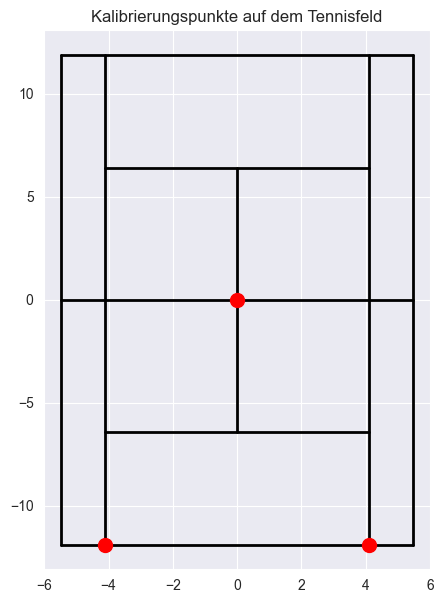

In [325]:
plt.figure(figsize=(5, 7))
drawTennisField()
plt.plot([0], [0], color = 'r', marker = 'o', markersize=10)
plt.plot([-4.11], [-11.89], color = 'r', marker = 'o', markersize=10)
plt.plot([4.11], [-11.89], color = 'r', marker = 'o', markersize=10)
plt.title("Kalibrierungspunkte auf dem Tennisfeld")

Achtung! Stereolabs hat verschieden Koordinatensysteme. In unserem Fall muss die Z-Achse umgedreht werden, da die Kamera die Z-Achse negativ ausgibt.

In [326]:
# Kooridnaten auf dem Tennisfeld als Kalibrierung
P1=np.array([-4.207, -1.846, 5.733]) # Linke Ecke an der Grundlinie X Seitenlinie Einzelfeld
P2=np.array([3.415, -1.870, 5.489]) # Rechte Ecke an der Grundlinie X Seitenlinie Einzelfeld
P3=np.array([-0.057, -1.703, 15.554]) # Mittelpunkt am Netz

In [327]:
df_cam["z"] = df_cam["z"].apply(abs)

### Transformation der Koordinaten

In [328]:
df_cam[['new_x', 'new_y', 'new_z']] = df_cam.apply(lambda row: pd.Series(tennisfeld(np.array([row['x'], row['y'], row['z']]), P1, P2, P3)), axis=1)
#Alte Koordinaten entfernen
df_cam.drop(columns=["x", "y", "z"], inplace=True)

### Visualisierung auf dem Tennisfeld

Die transformierten Koordinaten werden nun auf dem Tennisfeld visualisiert. Wir ploten die Koordinaten auf dem Feld und färben sie nach dem Frame ein.

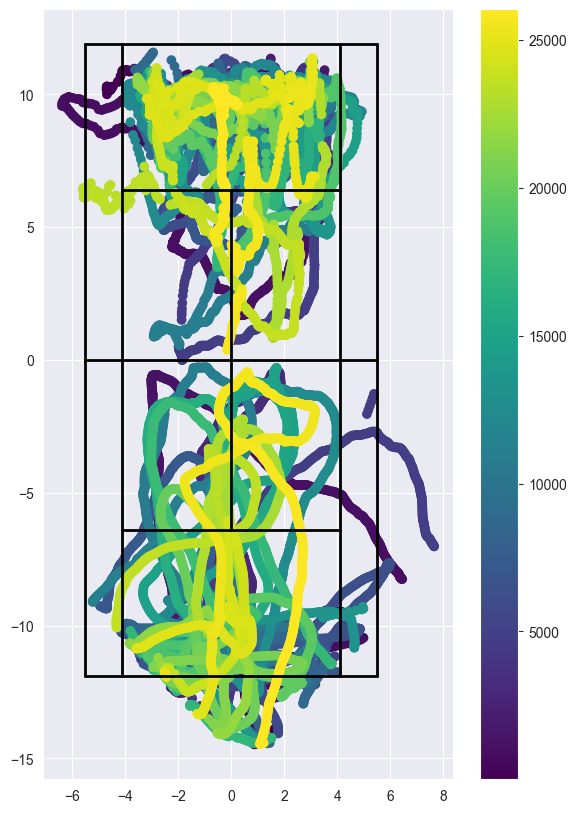

In [329]:
fig, ax = plt.subplots(figsize=(7, 10))
plt.scatter(x=df_cam['new_x'], y=df_cam['new_z'], c=df_cam['frame'], cmap='viridis')
drawTennisField()
plt.colorbar()
ax.set_aspect('equal')
plt.show()

Man sieht das die Position der Spieler verzerrt ist, da beide Spieler hinter der Grundlinie stehen. 

Wir sehen, dass die Kamera den ersten Spieler sehr gut erkennt, aber der zweite Spieler scheint etwas zu weit vorne zu stehen. 
Wir geben dem zweiten Spieler einen Offset von 2m nach hinten.

### Offset

Wir testen nun on man das Problem mit einem Offset lösen kann.

In [330]:
df_offset = df_cam.copy()

In [331]:
df_offset.loc[df_offset["object_id"] == "Player2", "new_z"] = df_offset.loc[df_offset["object_id"] == "Player2", "new_z"] + 2

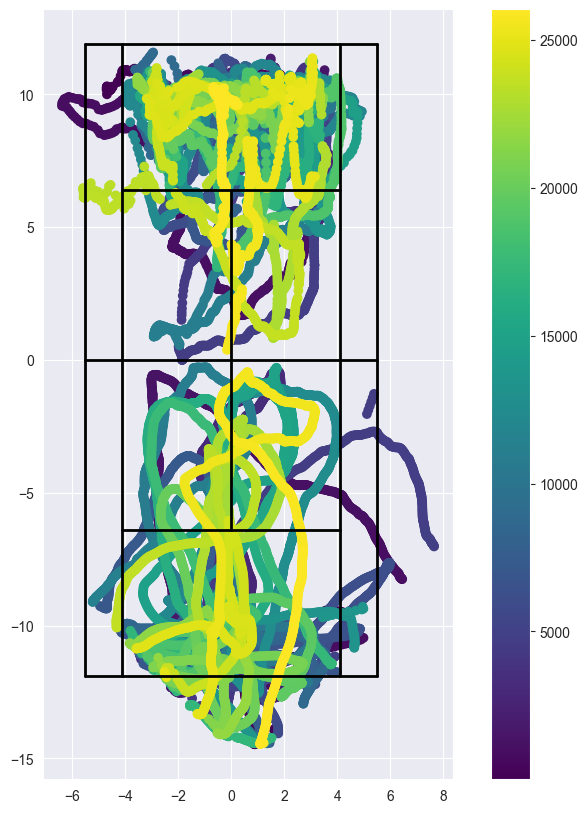

In [332]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x=df_offset['new_x'], y=df_offset['new_z'], c=df_offset['frame'], cmap='viridis')
drawTennisField()
plt.colorbar()
ax.set_aspect('equal')
plt.show()

Das Ergebnis zeigt das die Koordinaten verzert sind und nicht verschoben. 

### Objekt ID anpassen

Die Kamera wechselt object_id hinweg über die ganze Aufnahme. Wir schauen die kleinen Werte der Z-Koordiante einmal an und beobachten ob wir nach die Labls so neu setzten können

In [333]:
df_cam.loc[(df_cam["new_z"] < 0.5) & (df_cam["new_z"] > -0.5)]["new_z"]

5471    -0.499619
5473    -0.491837
5475    -0.482823
5477    -0.455255
5479    -0.437178
           ...   
41794   -0.457440
41796   -0.460615
41798   -0.480184
41800   -0.491510
41904    0.383994
Name: new_z, Length: 138, dtype: float64

Vergleicht man die Position mit der Aufnahme sollte diese Unterscheidung möglich sein.

In [334]:
df_cam["object_id"] = np.where(df_cam["new_z"] < 0, "Player1", "Player2")

### Start und Endzeitpunkt

Die Kamera gibt die Position für beide Spieler in einer seperaten Zeile aus. Da sie aber im gleichen Frame aufgenommen wurden, können wir diese zusammenführen.

Um Fehler auszuschliessen schneiden wir die Daten anhand der Labels, da wir Start und Endzeitpunkt kennen.

In [335]:
max_label = df_labels["Frame"].max()
min_label = df_labels["Frame"].min()
df_cam = df_cam[(df_cam["frame"] >= min_label) & (df_cam["frame"] <= max_label)]

### Doppelte Frames

Wir suchen nun nach Fehler bei der zuordnung der object_id. Dazu suchen wir nach doppelten Frames und wo die Id gleich ist mit stark unterschiedlichen Koordinaten.

In [336]:
df_cam[df_cam.duplicated(subset=["frame", "object_id"], keep=False)]

,frame,object_id,confidence,vx,xy,vz,width,height,length,new_x,new_y,new_z
8106,4656,Player1,73.63281,1.16439,-0.14408,0.71219,0.76300,1.71601,0.76300,4.384906,0.619867,-2.962067
8107,4656,Player1,39.42871,-1.69956,1.20401,-4.43874,0.50030,1.36696,0.50030,5.382167,1.065237,-1.273686
8109,4657,Player1,80.02930,1.15043,-0.15277,0.73953,0.79749,1.71923,0.79749,4.419609,0.627798,-2.924905
8110,4657,Player1,39.42871,-1.69956,1.20390,-4.43877,0.49975,1.33971,0.49975,5.332197,1.020376,-1.424707
8112,4658,Player1,79.73633,1.15107,-0.14749,0.72151,0.81960,1.72088,0.81960,4.456541,0.633862,-2.899881
...,...,...,...,...,...,...,...,...,...,...,...,...
31312,19095,Player1,63.18359,1.67078,0.65544,-1.92634,0.50409,1.72972,0.50409,-3.102932,-2.509434,-11.188105
31313,19096,Player1,25.46387,-0.03794,-0.06210,0.20523,0.50116,0.25719,0.50116,-2.168812,-2.800008,-12.242581
31314,19096,Player1,65.23438,2.35704,0.96652,-2.85958,0.50417,1.70902,0.50417,-2.956192,-2.557168,-11.362464
31315,19097,Player1,25.46387,-0.03794,-0.06212,0.20523,0.50122,0.25418,0.50122,-2.170290,-2.799304,-12.235545


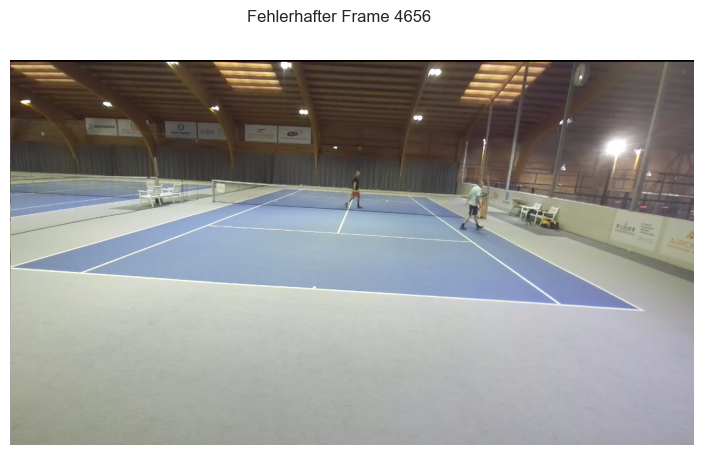

In [337]:
from PIL import Image as PILImage
import matplotlib.pyplot as plt

# Lade Bilder
img1 = PILImage.open("../image/grafik.png")

plt.figure(figsize=(10, 5))
plt.imshow(img1)
plt.axis('off') 
plt.suptitle("Fehlerhafter Frame 4656", fontsize=12)
plt.show()

Hier ein Beispiel für ein fehlerhafter Frame. Es ist nicht ganz klar wieso die Kamera die Objekte nicht erkennt. Glücklicherweise kommt es nur 68 mal vor. Diese Beispiel hat auch keinen Einfluss, da das Spiel unterbrochen ist.

In [338]:
df_cam = df_cam.drop_duplicates(subset=["frame", "object_id"], keep=False)

### NaN Werte

In [339]:
df_cam[df_cam.isna().any(axis=1)]

,frame,object_id,confidence,vx,xy,vz,width,height,length,new_x,new_y,new_z


Im Dateframe sind 6 Zeilen mit Nan vorhaden. Vergleichen wir mit der Kamera verschwindet Spieler 1, doch die Koordinaten des 2ten Spielers verschwinden. Wir belassen die Zeilen im Dataframe, da auch diese Fehler in der inaktiven Phase auftreten.

### Duplikate

Vorhin haben wir schon nach Duplikate gesucht, aber nur nach Frames und IDs. Wir schauen nun ob es Duplikate im ganzen Dataframe gibt.

In [340]:
df_cam[df_cam.duplicated()]

,frame,object_id,confidence,vx,xy,vz,width,height,length,new_x,new_y,new_z


Wir sehen das keine Duplikate vorhanden sind.

In [341]:
df_cam_wrangled = df_cam.copy()

## Merge der beiden Dataframes

Um die beiden Dataframes zu verbinden müssen wir das Dataframe so umformen das auf jeder Zeile ein Frame ist

In [342]:
df_cam_pivot = pd.pivot(df_cam_wrangled, index="frame", columns="object_id", values=["new_x", "new_y", "new_z", 'vx', 'xy', 'vz', 'width', 'height', 'length'])
#Collapse the MultiIndex
df_cam_pivot.columns = df_cam_pivot.columns.map('_'.join).str.strip()
#Reset Index to get the Name column back
df_cam_pivot = df_cam_pivot.reset_index()

In [343]:
df_cam_pivot.head()

,frame,new_x_Player1,new_x_Player2,new_y_Player1,new_y_Player2,new_z_Player1,new_z_Player2,vx_Player1,vx_Player2,xy_Player1,xy_Player2,vz_Player1,vz_Player2,width_Player1,width_Player2,height_Player1,height_Player2,length_Player1,length_Player2
0,287,0.488342,-2.556822,-1.157367,5.167203,-9.915421,9.479640,0.01540,-0.06328,-0.04420,0.04720,0.15406,-0.17333,0.64888,0.61570,1.99435,1.17692,0.64888,0.61570
1,288,0.487970,-2.551163,-1.155410,5.141961,-9.916995,9.366557,0.02580,-0.05046,-0.03045,0.03763,0.10899,-0.13822,0.66799,0.61899,1.97376,1.17656,0.66799,0.61899
2,289,0.487290,-2.544400,-1.155982,5.116309,-9.917908,9.280055,0.02339,-0.06145,-0.02760,0.04583,0.09879,-0.16830,0.68904,0.62047,1.95456,1.17893,0.68904,0.62047
3,290,0.482031,-2.544177,-1.156393,5.107507,-9.918351,9.270463,0.02728,-0.04928,-0.03218,0.03674,0.11523,-0.13497,0.71109,0.62504,1.95276,1.18399,0.71109,0.62504
4,291,0.477606,-2.544681,-1.157121,5.102722,-9.919782,9.268751,0.01641,-0.04386,-0.01936,0.03270,0.06932,-0.12013,0.73265,0.62681,1.94945,1.17943,0.73265,0.62681


Man sieht nun dass das Dataframe eine Spalten mehr hat, für beide Spieler nun die Koordinaten etc. vorhanden sind.

In [344]:
df = pd.merge(df_cam_pivot, df_labels, left_on="frame", right_on="Frame", how="left")
df = df.drop(columns=["Frame"])

Da die Labels nur gesetzt wurde wenn ein Event stattgefunden hat, sind die meisten Werte NaN. Bei Status und Satz kann man aber die Werte auffüllen.

In [345]:
df[["Status", "Satz"]] = df[["Status", "Satz"]].ffill()

### Aktiv Datensatz

Um nicht Daten auszuwerten die während der Unterbrechung aufgenommen wurden, entfernen wir alle Frames die inaktiv sind. Da einzelnen methoden der Zeitreihen Analyse anfällig für Lücken ist, wird für den im Abschnitt Zeitrehenanalyse  ein Dataframe mit den einaktiven Frames behaltet.

In [346]:
df_inactiv = df.copy()
data = df.copy()
df = df.loc[df["Status"] != "Inaktiv"]

### Dataframe mit Geschwindigkeit ergänzen

Aus der Geschwindigkeit der Achsen können wir die Geschwindigkeit der Spieler berechnen. In dem wir die Geschwindigkeit der Achsen quadrieren und dann die Wurzel ziehen um den Betrag des Vektoren zu bekommen.

In [347]:
df["geschwindigkeit_p1"] = np.sqrt(df["vx_Player1"] ** 2 + df["xy_Player1"] ** 2 + df["vz_Player1"] ** 2)
df["geschwindigkeit_p2"] = np.sqrt(df["vx_Player2"] ** 2 + df["xy_Player2"] ** 2 + df["vz_Player2"] ** 2)

data["geschwindigkeit_p1"] = np.sqrt(data["vx_Player1"] ** 2 + data["xy_Player1"] ** 2 + data["vz_Player1"] ** 2)
data["geschwindigkeit_p2"] = np.sqrt(data["vx_Player2"] ** 2 + data["xy_Player2"] ** 2 + data["vz_Player2"] ** 2)

df.drop(columns=['vx_Player1', 'vx_Player2', 'xy_Player1', 'xy_Player2', 'vz_Player1', 'vz_Player2'], inplace=True)

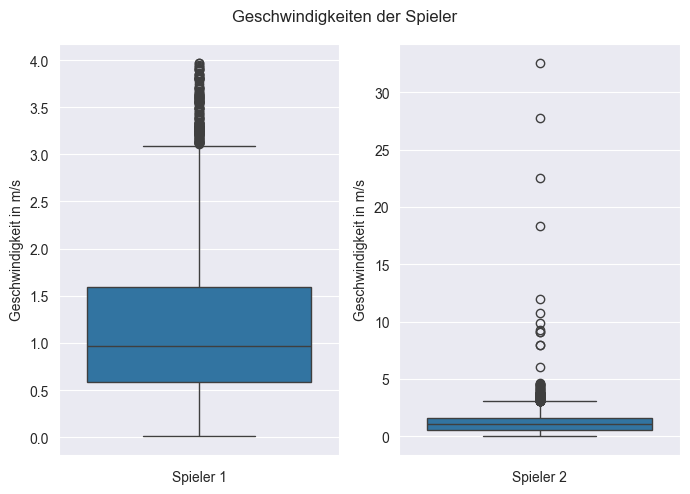

In [348]:
plt.figure(figsize=(7, 5))

plt.suptitle("Geschwindigkeiten der Spieler", fontsize=12)
plt.subplot(121)
sns.boxplot(y=df["geschwindigkeit_p1"])
plt.ylabel("Geschwindigkeit in m/s")
plt.xlabel("Spieler 1")

plt.subplot(122)
sns.boxplot(y=df["geschwindigkeit_p2"])
plt.ylabel("Geschwindigkeit in m/s")
plt.xlabel("Spieler 2")
plt.tight_layout()
plt.show()

Die Geschwindigkeiten des ersten Spielers scheint richtig erkannt zu werden. Beim zweiten Spieler gibt es einige Aussreisser die sicher nicht stimmen können. Wir schauen uns die Werte genauer an. (30m/s = 108km/h)

Da die Geschwindigkeit pro frame ausgegeben wird und wir 30 frames in einer Sekunde haben probieren wir die Geschwindigkeit zu glätten. Wir nehmen den Median der letzten 5 Frames.

In [349]:
rolled = df.copy()

In [350]:
rolled["geschwindigkeit_p1"] = df["geschwindigkeit_p1"].rolling(5, min_periods=1).median()
rolled["geschwindigkeit_p2"] = df["geschwindigkeit_p2"].rolling(5, min_periods=1).median()

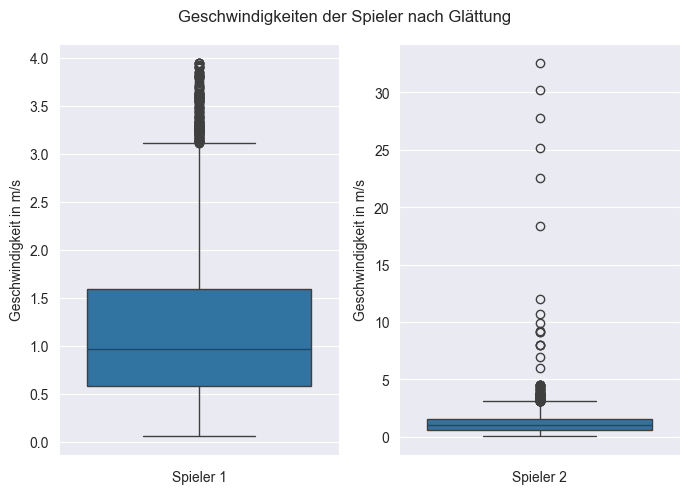

In [351]:
plt.figure(figsize=(7, 5))
plt.suptitle("Geschwindigkeiten der Spieler nach Glättung", fontsize=12)
plt.subplot(121)
sns.boxplot(y=rolled["geschwindigkeit_p1"])
plt.ylabel("Geschwindigkeit in m/s")
plt.xlabel("Spieler 1")

plt.subplot(122)
sns.boxplot(y=rolled["geschwindigkeit_p2"])
plt.ylabel("Geschwindigkeit in m/s")
plt.xlabel("Spieler 2")
plt.tight_layout()
plt.show()

Rolling hat nicht den gewünschten Effekt gebracht. Die einzige Änderung die auffält ist das Spieler 1 keine 0 Werte mehr hat.

Der nächste Schritt ist die Geschwindigkeit selber zu mit den Kooridnaten zu berechnen. 

### Geschwindigkeit selber berechnen

Von den Boxplot entnehmen wird as eine bei den Geschwindigkeiten über 5m/s eine Lücke gibt wir probieren also Werte die über 5m/s sind zu berechnen.

In [352]:
wrong_vek = df.loc[(df["geschwindigkeit_p2"] > 5) ][["new_x_Player2", "new_y_Player2", "new_z_Player2", "geschwindigkeit_p2","geschwindigkeit_p1"]]

In [353]:
wrong_vek

,new_x_Player2,new_y_Player2,new_z_Player2,geschwindigkeit_p2,geschwindigkeit_p1
21989,-3.264604,4.565416,7.286928,32.571755,0.864924
21990,-3.155840,4.367968,6.734826,27.763435,0.860337
21991,-3.158784,4.291372,6.504711,22.529411,0.814327
21992,-3.203435,4.260257,6.391001,18.360929,0.772926
21993,-3.293883,4.390630,6.837887,12.008363,0.700277
21994,-3.428662,4.385916,6.739789,10.722756,0.626688
21995,-3.590879,4.385528,6.708443,9.250353,0.557555
21996,-3.709065,4.330959,6.471290,9.104014,0.502482
21997,-3.781126,4.196840,6.002809,9.873426,0.438828
21998,-3.845200,4.155669,5.874594,9.125721,0.357312


Die grossen Sprünge sind alle von einem Ausschnitt im Spiel.

Wir machen die berechnung also so simple wie möglich und berechen die Geschwindigkeit mit der Differenz des ersten und letzten Frames. Das ist eine sehr grobe Schätzung, da es aber nur 13 Frames also noch nicht einmal eine halbe Sekunde ist sollte es reichen.

In [354]:
vect = wrong_vek[-1:].values - wrong_vek[:1].values
dist = np.sqrt(vect[:,0] ** 2 + vect[:,1] ** 2 + vect[:,2] ** 2)
time = 13 / 30
speed = dist / time
df["geschwindigkeit_p2"].values[(df["geschwindigkeit_p2"].values > 5) ] = speed

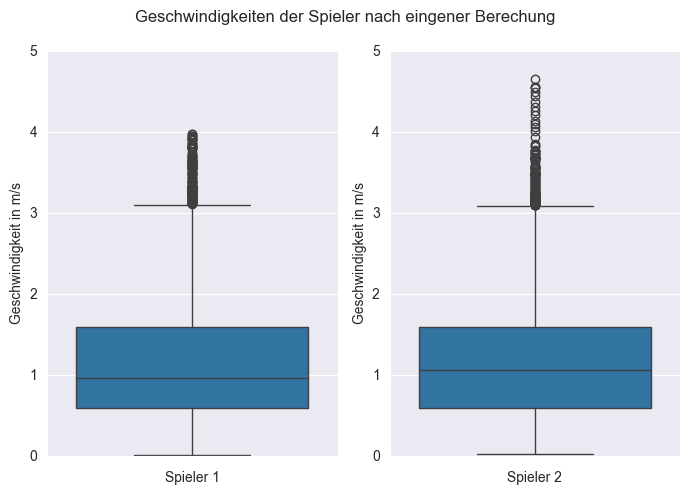

In [355]:
plt.figure(figsize=(7, 5))
plt.suptitle("Geschwindigkeiten der Spieler nach eingener Berechung", fontsize=12)
plt.subplot(121)
sns.boxplot(df["geschwindigkeit_p1"])
plt.ylim(0, 5)
plt.ylabel("Geschwindigkeit in m/s")
plt.xlabel("Spieler 1")

plt.subplot(122)
sns.boxplot(y=df["geschwindigkeit_p2"])
plt.ylim(0, 5)
plt.ylabel("Geschwindigkeit in m/s")
plt.xlabel("Spieler 2")
plt.tight_layout()
plt.show()

Mit der eigenen Berechnung sind die Werte nun realistischer. Wir sehen das alle Werte in einem realistischen Bereich sind.

### Zone auf dem Feld

Für spätere Analysen ist es wichtig zu wissen wo sich die Spieler auf dem Feld befinden. Wir teilen das Feld in 4 Zonen ein. Sehr Offensiv, Offensiv, Neutral und Defensiv. Gleichzeitig teilen wir das Feld in 3 Positionen ein. Links, Mitte und Rechts. 

In [356]:
#
df["zone_p1"] = df["new_z_Player1"].apply(zonen)
df["zone_p2"] = df["new_z_Player2"].apply(zonen)
#
df["pos_p1"] = df["new_x_Player1"].apply(position)
df["pos_p2"] = df["new_x_Player2"].apply(position)

### Letzte Anpassung der Datentypen

In [357]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5538 entries, 0 to 23973
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   frame               5538 non-null   int64  
 1   new_x_Player1       5449 non-null   float64
 2   new_x_Player2       4787 non-null   float64
 3   new_y_Player1       5449 non-null   float64
 4   new_y_Player2       4787 non-null   float64
 5   new_z_Player1       5449 non-null   float64
 6   new_z_Player2       4787 non-null   float64
 7   width_Player1       5449 non-null   float64
 8   width_Player2       4787 non-null   float64
 9   height_Player1      5449 non-null   float64
 10  height_Player2      4787 non-null   float64
 11  length_Player1      5449 non-null   float64
 12  length_Player2      4787 non-null   float64
 13  Status              5538 non-null   object 
 14  Schlag_p1           75 non-null     object 
 15  Schlag_p2           62 non-null     object 
 16  Satz      

Bevor das Dataframe nun für die Explorative Datenanalyse verwendet werden kann, müssen wir noch die Datentypen anpassen, die vom Gelabelten Dataframe übernommen wurden.

In [358]:
df["Status"] = df["Status"].astype("category")
df["Schlag_p1"] = df["Schlag_p1"].astype("category")
df["Schlag_p2"] = df["Schlag_p2"].astype("category")
df["Satz"] = df["Satz"].astype("category")
df["zone_p1"] = df["zone_p1"].astype("category")
df["zone_p2"] = df["zone_p2"].astype("category")
df["pos_p1"] = df["pos_p1"].astype("category")
df["pos_p2"] = df["pos_p2"].astype("category")
df["Fehler_p1"] = df["Fehler_p1"].astype("category")
df["Fehler_p2"] = df["Fehler_p2"].astype("category")


# Explorative Datenanalyse

In [359]:
df.shape

(5538, 25)

Index zurücksetzten für spätere Analyse

In [360]:
df.reset_index(drop=True, inplace=True)

Wir haben nun für die Explorative Datenanalyse 5538 Frames, in diesen das Spiel aktiv läuft.

In [361]:
df.describe(include="all")

,frame,new_x_Player1,new_x_Player2,new_y_Player1,new_y_Player2,new_z_Player1,new_z_Player2,width_Player1,width_Player2,height_Player1,...,Schlag_p2,Satz,Fehler_p1,Fehler_p2,geschwindigkeit_p1,geschwindigkeit_p2,zone_p1,zone_p2,pos_p1,pos_p2
count,5538.000000,5449.000000,4787.000000,5449.000000,4787.000000,5449.000000,4787.000000,5449.000000,4787.000000,5449.000000,...,62,5538.0,22,10,5449.000000,4787.000000,5538,5538,5538,5538
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,3.0,4,3,NaN,NaN,4,4,3,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Fronthand,3.0,Aufschlagfehler,Netz,NaN,NaN,Neutral,Neutral,Mitte,Mitte
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31,2987.0,7,5,NaN,NaN,4641,3238,3734,3055
mean,11106.260563,-0.400948,0.684688,-1.312534,4.773249,-10.116067,9.067450,0.825033,0.713452,1.756707,...,NaN,NaN,NaN,NaN,1.165484,1.192014,NaN,NaN,NaN,NaN
std,7612.009150,1.547804,1.874862,0.576069,0.554516,1.769867,1.721171,0.177810,0.085318,0.079917,...,NaN,NaN,NaN,NaN,0.770693,0.776931,NaN,NaN,NaN,NaN
min,287.000000,-4.152590,-6.365507,-2.564604,2.083407,-12.531677,0.003769,0.503380,0.503640,1.114770,...,NaN,NaN,NaN,NaN,0.011985,0.021613,NaN,NaN,NaN,NaN
25%,3905.250000,-1.378311,-0.349279,-1.711116,4.583699,-11.308802,8.526656,0.702420,0.658070,1.715220,...,NaN,NaN,NaN,NaN,0.584052,0.588724,NaN,NaN,NaN,NaN
50%,10420.500000,-0.477857,0.955436,-1.386131,4.960105,-10.444174,9.655178,0.792780,0.706660,1.762010,...,NaN,NaN,NaN,NaN,0.962073,1.058394,NaN,NaN,NaN,NaN
75%,18442.750000,0.375747,2.088762,-1.099705,5.131891,-9.626821,10.186909,0.903750,0.759730,1.798080,...,NaN,NaN,NaN,NaN,1.592533,1.587839,NaN,NaN,NaN,NaN


Wir machen eine kurze Analyse mit describe, um zu sehen ob es auffällige Werte gibt.
- Wir haben für die Analyse 23975 Frames, wo bei ein paar wegfallen, weil die Kamera die Objekte nicht erkannt hat.
- Bei den Kooridante fallen geraden keine auffälligen Werte auf.
- Bei den heights sieht man das Spieler 1 grösser ist als Spieler 2.
- Das der Status mehrheitlich inaktiv ist, ist auch logisch da unterbrüche teilweise etwas länger dauern. Wie lassen dennoch die inactiven Frames im Spiel, um vileicht ein Muster zu erkennen ob der Spieler inaktiv ist.
- Was bei der Aufnahme auch auffgefallen ist, dass der Spieler 1 viel das Spiel startet. 
- Bei den Geschwindigkeiten scheint es ein paar Ausreisser zu geben, die noch untersucht werden müssen.

### Verteilung der Konutinuierlichen Variablen

In [362]:
cont_col = ["new_x_Player1", "new_x_Player2", "new_y_Player1", "new_y_Player2", "new_z_Player1", "new_z_Player2", "width_Player1", "width_Player2", "height_Player1", "height_Player2", "length_Player1", "length_Player2", "geschwindigkeit_p1", "geschwindigkeit_p2"]
cat_col = ["Schlag_p1", "Schlag_p2", "Satz", "zone_p1", "zone_p2", "pos_p1", "pos_p2","Fehler_p1", "Fehler_p2"]


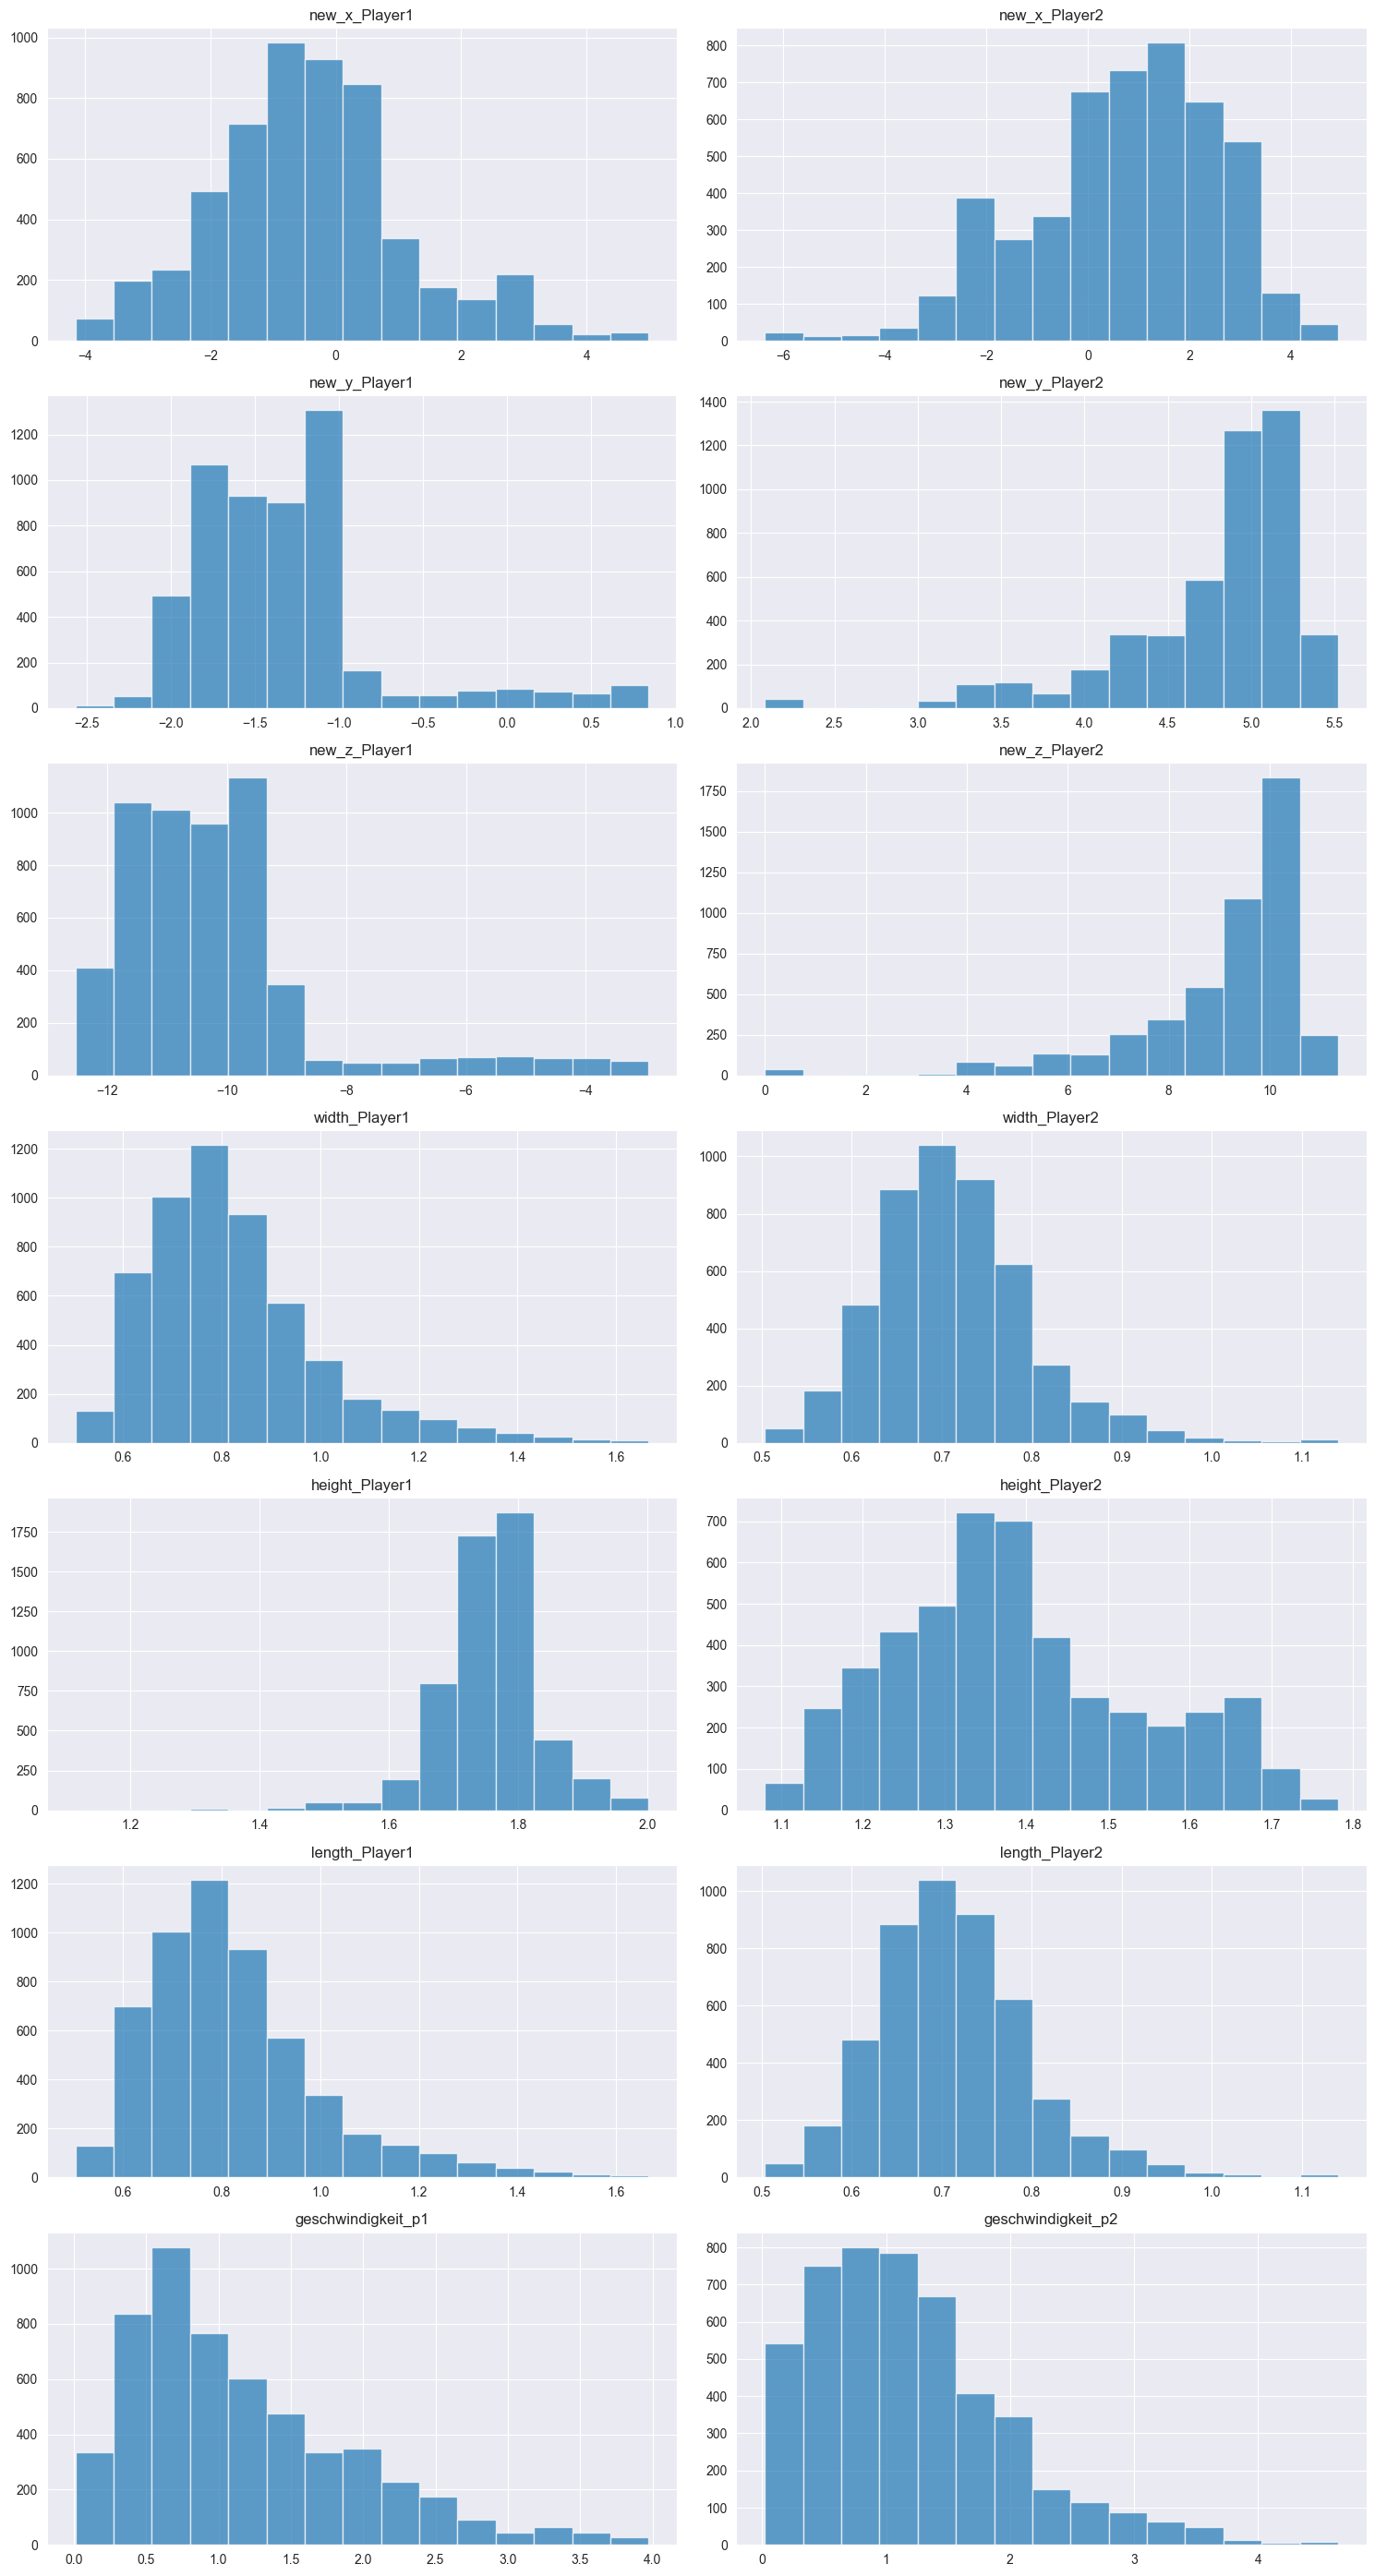

In [363]:
# Histogramme mit zwei Spalten pro Zeile
fig, axes = plt.subplots(len(cont_col) // 2 + len(cont_col) % 2, 2, figsize=(15, 4 * (len(cont_col) // 2 + len(cont_col) % 2)))
axes = axes.ravel()  # Flach machen des Achsen-Arrays für einfacheren Zugriff

for i, col in enumerate(cont_col):
    axes[i].hist(df[col], bins=15, alpha=0.7)
    axes[i].set_title(col)

# Restliche, ungenutzte Plots ausblenden
for i in range(len(cont_col), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### Verteilung der Kategorialen Variablen

C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python3

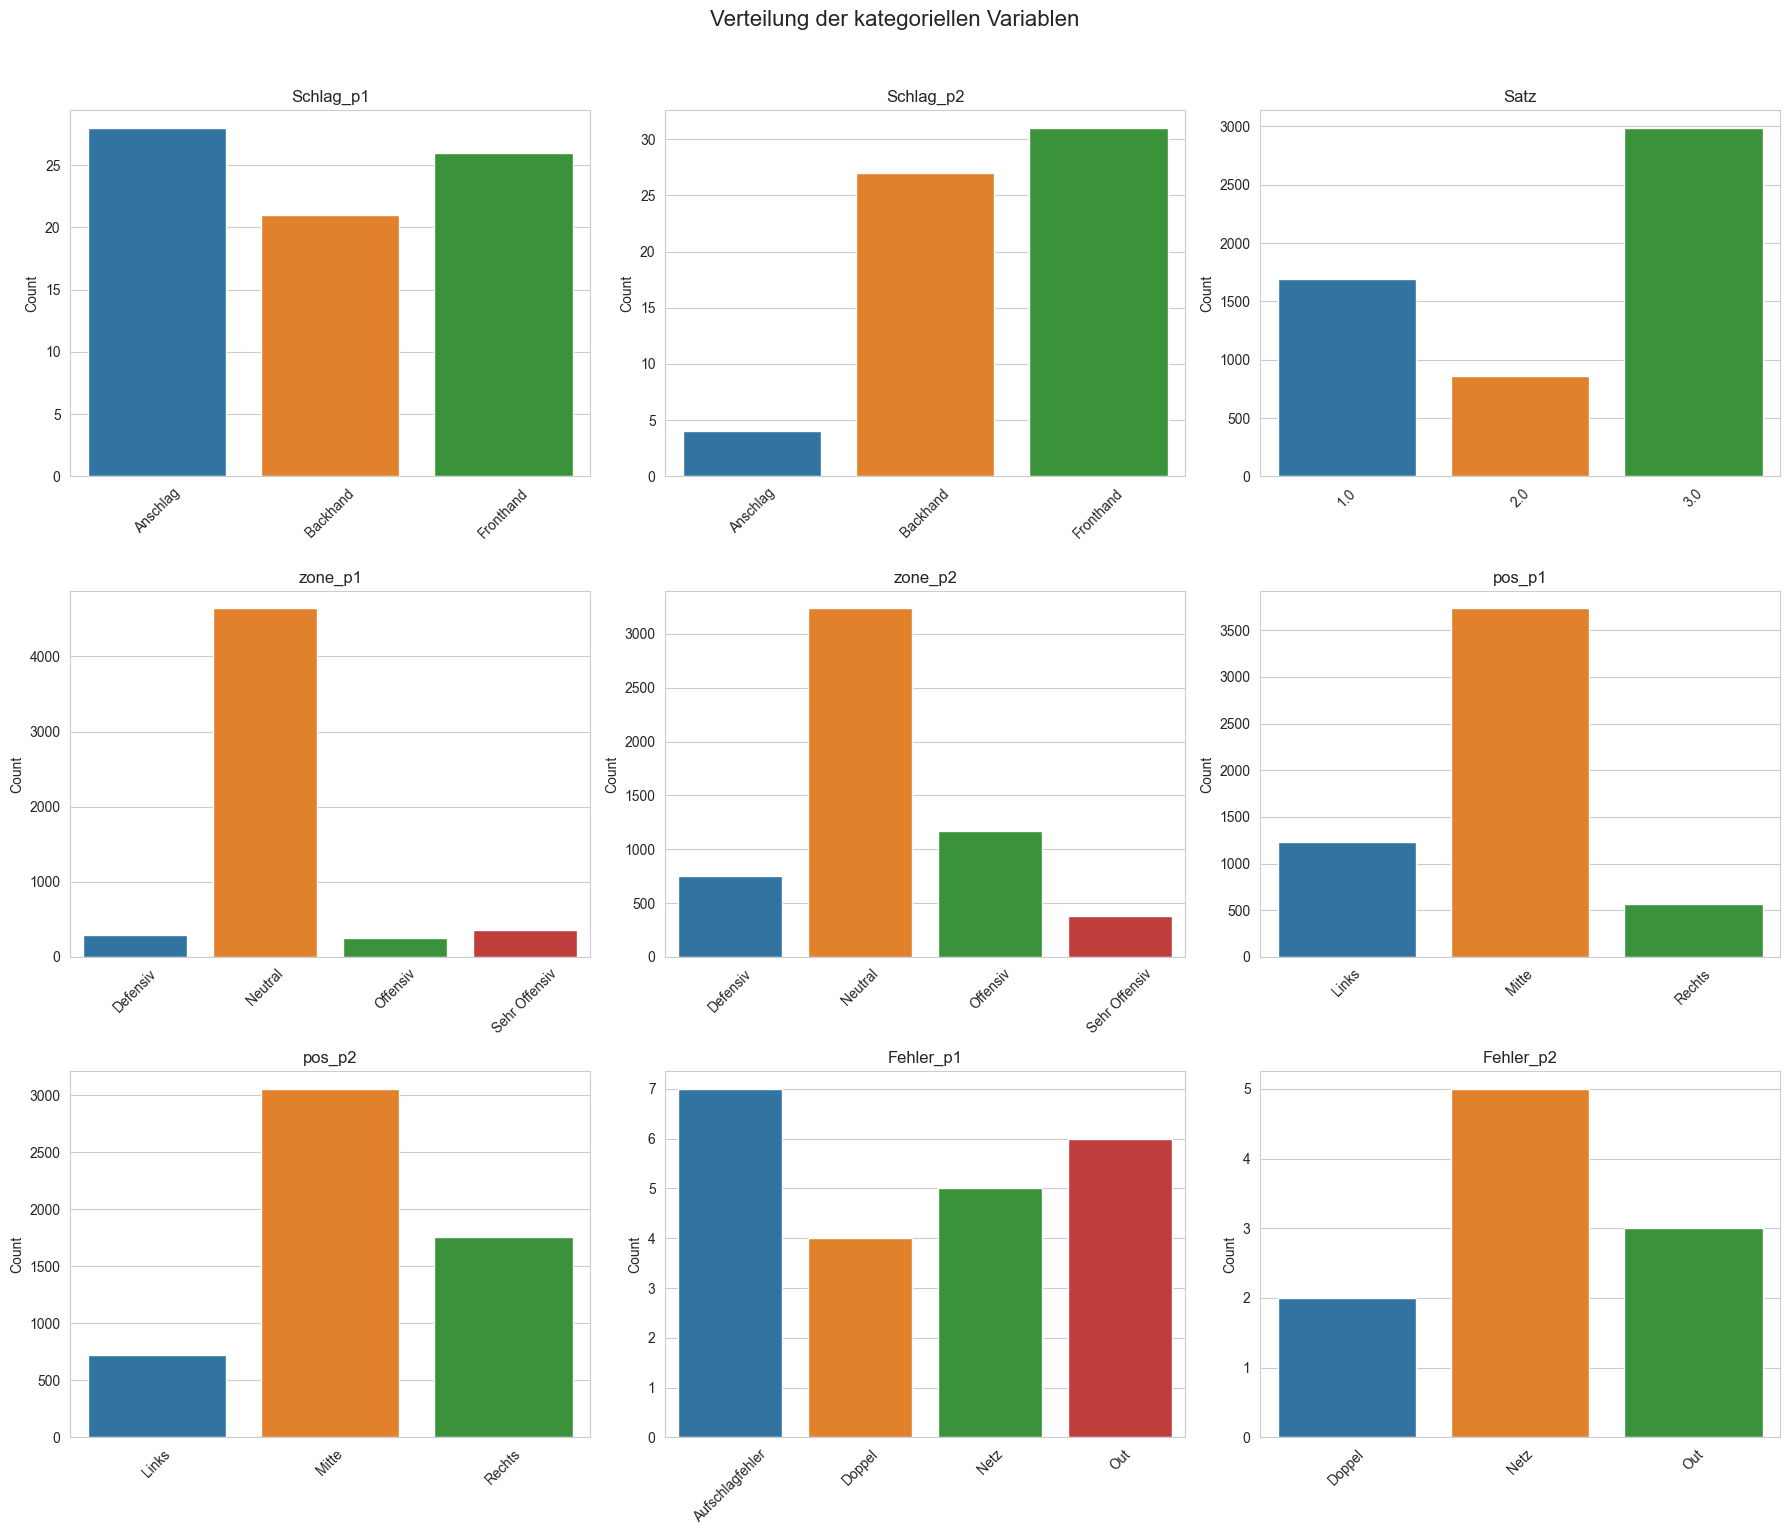

In [493]:
# Countplot für jede kategorielle Spalte erstellen
fig, axes = plt.subplots(3,3, figsize=(18,15))
axes = axes.ravel()  # Flach machen des Achsen-Arrays für einfacheren Zugriff
plt.suptitle("Verteilung der kategoriellen Variablen", fontsize=16,y=1.02)
for i, col in enumerate(cat_col):
    sns.countplot(x=df[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)  # Beschriftung um 45 Grad drehen

# Restliche, ungenutzte Plots ausblenden
for i in range(len(cat_col), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Auffälliges der Kategorien:
- Beide Spieler bevorzugen den Ball mit der Fronthand zu schlagen.
- Spieler 1 hat aber einiges mehr Anschläge als Spieler 2. Das vorallem weil Spieler 1 im dritten Satz Anschlägt und das der längste Satz ist.
- Beide Spieler sind meistens in der Neutralen Zone und sind meistens in der Mitte des Feldes.
- Spieler 1 ist mehr auf der linken Spielseite und Spieler 2 mehr auf der rechten Spielseite. Was sich gut erklären lässt, da die Spieler den den Winkel des Schlägers anpassen müssen.

### Zurückgelegte Distanz

In [494]:
# Berechnen der Distanz für Player1
distanzen_player1 = np.sqrt((df['new_x_Player1'].diff()**2) + (df['new_y_Player1'].diff()**2) + (df['new_z_Player1'].diff()**2))
gesamtstrecke_player1 = distanzen_player1.sum()

# Berechnen der Distanz für Player2
distanzen_player2 = np.sqrt((df['new_x_Player2'].diff()**2) + (df['new_y_Player2'].diff()**2) + (df['new_z_Player2'].diff()**2))
gesamtstrecke_player2 = distanzen_player2.sum()

# Ergebnisse
print("Gesamtstrecke Player1:", gesamtstrecke_player1, "m")
print("Gesamtstrecke Player2:", gesamtstrecke_player2, "m")

Gesamtstrecke Player1: 325.7414666435218 m
Gesamtstrecke Player2: 388.9670061730378 m


Es scheint als hätte der Spieler 2 eine grössere Strecke zurückgelegt. Grundsätzlich ist der Unterschied von 50 Meter. Zu beachten ist das es nur die Distanz ist während die Spieler aktiv sind.

### Analyse der Fehler

Wir wollen sehen was die Auslöser für die Fehler sind. Dazu schauen wir uns die Fehler der Spieler an.

In [366]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5538 entries, 0 to 5537
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   frame               5538 non-null   int64   
 1   new_x_Player1       5449 non-null   float64 
 2   new_x_Player2       4787 non-null   float64 
 3   new_y_Player1       5449 non-null   float64 
 4   new_y_Player2       4787 non-null   float64 
 5   new_z_Player1       5449 non-null   float64 
 6   new_z_Player2       4787 non-null   float64 
 7   width_Player1       5449 non-null   float64 
 8   width_Player2       4787 non-null   float64 
 9   height_Player1      5449 non-null   float64 
 10  height_Player2      4787 non-null   float64 
 11  length_Player1      5449 non-null   float64 
 12  length_Player2      4787 non-null   float64 
 13  Status              5538 non-null   category
 14  Schlag_p1           75 non-null     category
 15  Schlag_p2           62 non-null     ca

In [367]:
def zaehle_schlaege_vor_fehler(dataframe, fehler_typ, Fehler_p):
    schlag_count = {'Backhand': 0, 'Fronthand': 0}

    # Für jeden Frame, in dem ein Fehler von Spieler 1 aufgetreten ist
    for index, row in dataframe[dataframe[Fehler_p] == fehler_typ].iterrows():
        # Rückverfolgung zum letzten Schlag
        for backwards in range(index, -1, -1):
            # Überprüfen, ob in diesem Frame ein Schlag von Spieler 1 erfolgt ist
            if pd.notnull(dataframe.loc[backwards, 'Schlag_p1']):
                schlag = dataframe.loc[backwards, 'Schlag_p1']
                if schlag in schlag_count:
                    schlag_count[schlag] += 1
                    break
            # Überprüfen, ob in diesem Frame ein Schlag von Spieler 2 erfolgt ist
            elif pd.notnull(dataframe.loc[backwards, 'Schlag_p2']):
                schlag = dataframe.loc[backwards, 'Schlag_p2']
                if schlag in schlag_count:
                    schlag_count[schlag] += 1
                    break

    return schlag_count


p1_doppel = zaehle_schlaege_vor_fehler(df, 'Doppel', "Fehler_p1")
p1_out = zaehle_schlaege_vor_fehler(df, 'Out', "Fehler_p1")
p1_netz = zaehle_schlaege_vor_fehler(df, 'Netz', "Fehler_p1")

p2_doppel = zaehle_schlaege_vor_fehler(df, 'Doppel', "Fehler_p2")
p2_out = zaehle_schlaege_vor_fehler(df, 'Out', "Fehler_p2")
p2_netz = zaehle_schlaege_vor_fehler(df, 'Netz', "Fehler_p2")

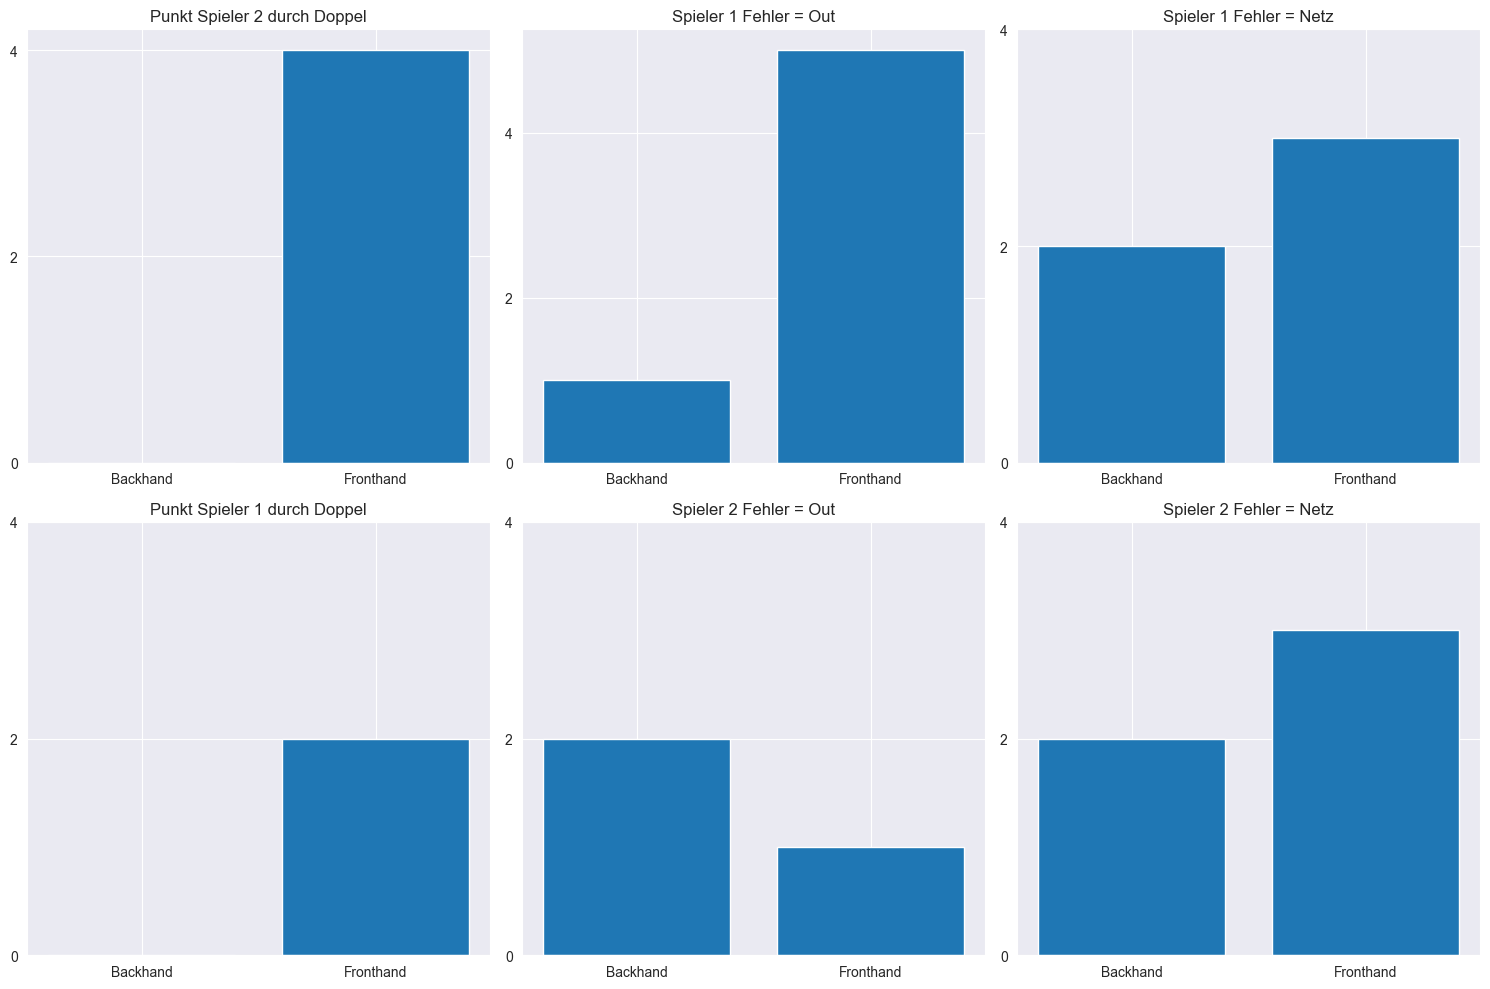

In [368]:
# Daten für Spieler 1
p1_doppel_counts = p1_doppel.values()
p1_out_counts = p1_out.values()
p1_netz_counts = p1_netz.values()

# Daten für Spieler 2
p2_doppel_counts = p2_doppel.values()
p2_out_counts = p2_out.values()
p2_netz_counts = p2_netz.values()

# Schlagtypen
schlag_typen = list(p1_doppel.keys())
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Spieler 1 Subplots
axes[0, 0].bar(schlag_typen, p1_doppel_counts)
axes[0, 0].set_title('Punkt Spieler 2 durch Doppel')

axes[0, 1].bar(schlag_typen, p1_out_counts)
axes[0, 1].set_title('Spieler 1 Fehler = Out')

axes[0, 2].bar(schlag_typen, p1_netz_counts)
axes[0, 2].set_title('Spieler 1 Fehler = Netz')

# Spieler 2 Subplots
axes[1, 0].bar(schlag_typen, p2_doppel_counts)
axes[1, 0].set_title('Punkt Spieler 1 durch Doppel')

axes[1, 1].bar(schlag_typen, p2_out_counts)
axes[1, 1].set_title('Spieler 2 Fehler = Out')

axes[1, 2].bar(schlag_typen, p2_netz_counts)
axes[1, 2].set_title('Spieler 2 Fehler = Netz')

for ax in axes.flatten():
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.set_yticks(np.arange(0, max(max(p1_doppel_counts), max(p2_doppel_counts)) + 1, 2))

plt.tight_layout()
plt.show()

## Vergleich der Geschwindigkeiten der Spieler

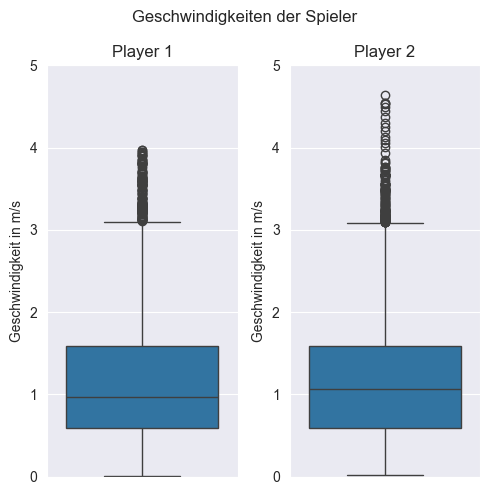

In [369]:
plt.figure(figsize=(5, 5))
plt.suptitle("Geschwindigkeiten der Spieler", fontsize=12)

plt.subplot(121)
sns.boxplot(df["geschwindigkeit_p1"])
plt.ylabel("Geschwindigkeit in m/s")
plt.ylim(0, 5)
plt.title("Player 1")

plt.subplot(122)
sns.boxplot(y=df["geschwindigkeit_p2"])
plt.ylabel("Geschwindigkeit in m/s")
plt.ylim(0, 5)
plt.title("Player 2")
plt.tight_layout()
plt.show()

Wenn wir die Geschwindigkeiten der Spieler vergleichen, während sie aktiv sind, sehen wir das Spieler 1 und 2 ungefähr gleich schnell sind. Spieler 2 scheint aber etwas schneller zu sein.

Um das etwas genauer zu untersuchen, vergleich wir die Geschwindigkeiten der Spieler über die 3 Sätze.

### Analyse der drei Sätze

In [370]:
df_satz1 = df.loc[df["Satz"] == 1]
df_satz2 = df.loc[df["Satz"] == 2]
df_satz3 = df.loc[df["Satz"] == 3]

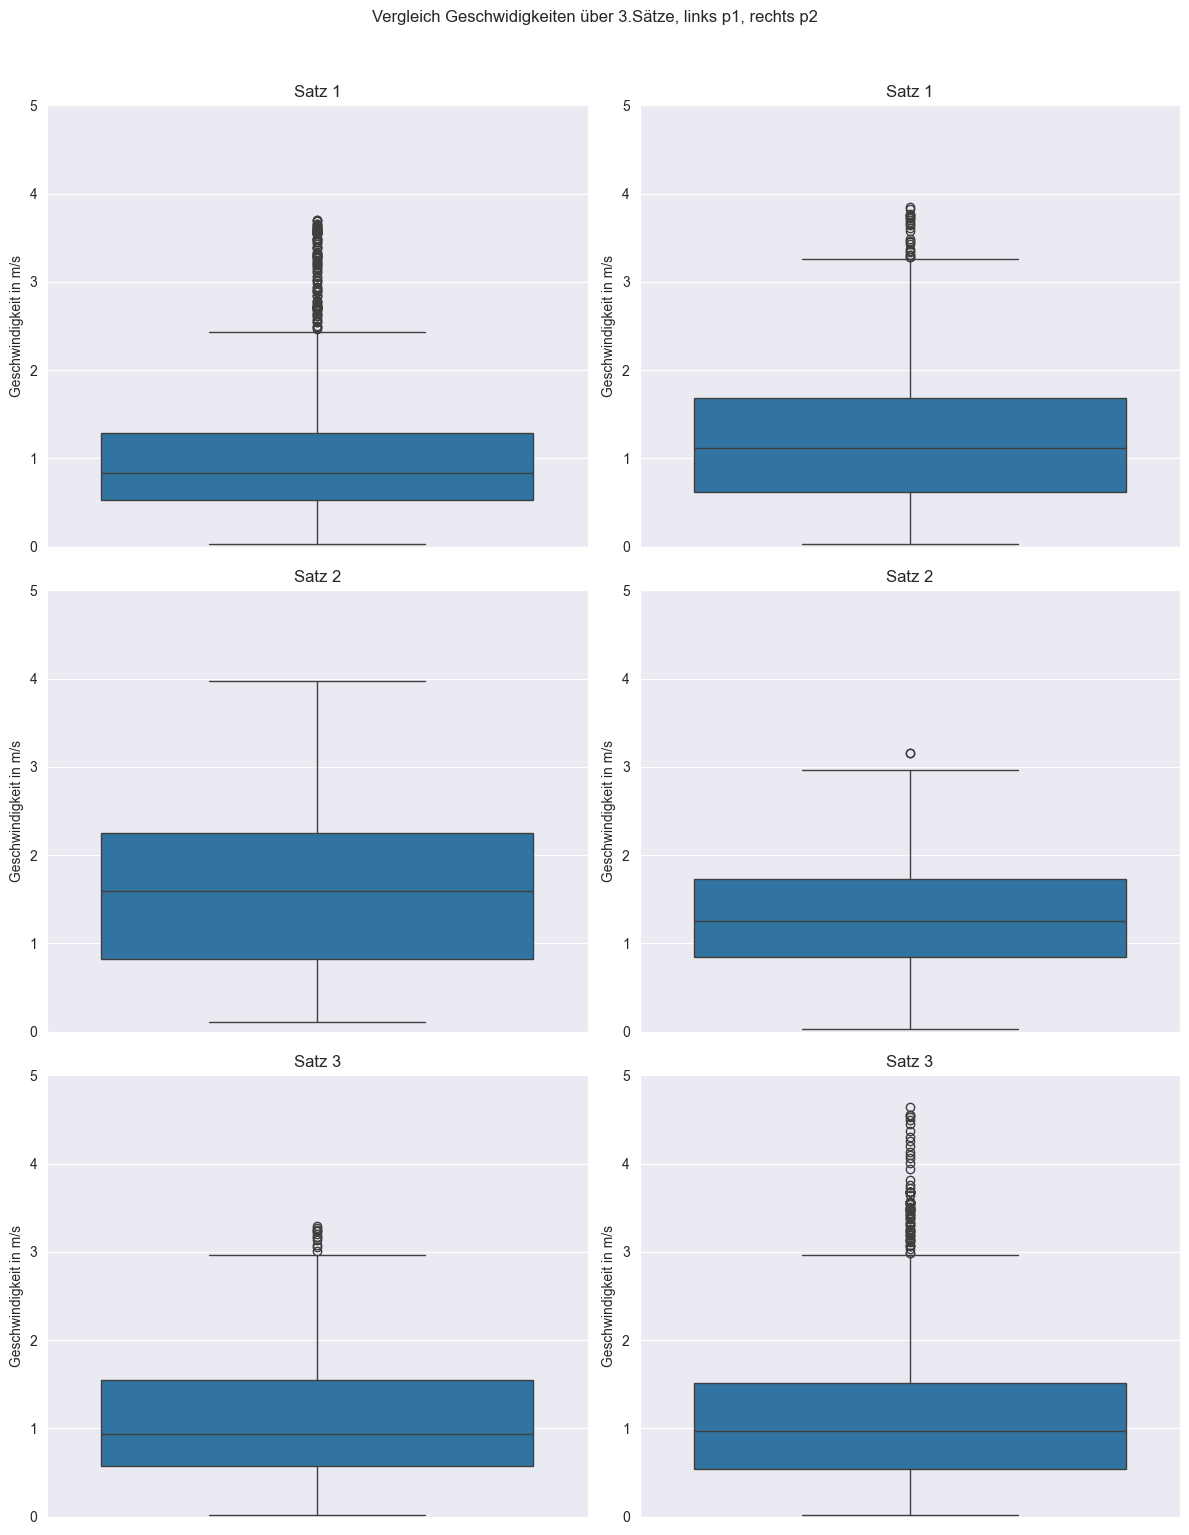

In [371]:
plt.figure(figsize=(12, 15))
plt.suptitle("Vergleich Geschwidigkeiten über 3.Sätze, links p1, rechts p2", y=1.02)

plt.subplot(321)
plt.title("Satz 1")
sns.boxplot(y="geschwindigkeit_p1", data=df_satz1)
plt.ylabel("Geschwindigkeit in m/s")
plt.ylim(0, 5)
plt.subplot(323)
plt.title("Satz 2")
sns.boxplot(y="geschwindigkeit_p1", data=df_satz2)
plt.ylabel("Geschwindigkeit in m/s")
plt.ylim(0, 5)
plt.subplot(325)
plt.title("Satz 3")
sns.boxplot(y="geschwindigkeit_p1", data=df_satz3)
plt.ylabel("Geschwindigkeit in m/s")
plt.ylim(0, 5)
plt.subplot(322)
plt.title("Satz 1")
sns.boxplot(y="geschwindigkeit_p2", data=df_satz1)
plt.ylabel("Geschwindigkeit in m/s")
plt.ylabel("Geschwindigkeit in m/s")
plt.ylim(0, 5)
plt.subplot(324)
plt.title("Satz 2")
sns.boxplot(y="geschwindigkeit_p2", data=df_satz2)
plt.ylabel("Geschwindigkeit in m/s")
plt.ylim(0, 5)
plt.subplot(326)
plt.title("Satz 3")
sns.boxplot(y="geschwindigkeit_p2", data=df_satz3)
plt.ylabel("Geschwindigkeit in m/s")
plt.ylim(0, 5)

plt.tight_layout()
plt.show()

- Im ersten Satz sieht man wie Spieler 2 mehrheitlich schneller ist als Spieler 1. Die maximal Geschwindigkeit scheint baer bei beiden Spieler vergleichbar zu sein. 
- Im zweiten Satz scheint Spieler 1 schneller und vorallem sich vermehrt zu bewegen. Der 2 Spieler scheint sich ähnlich zum ersten Satz zu verhalten. 
- Im dritten Satz fällt der Spieler 1 in sein Muster aus dem ersten Satz zurück. Spieler 2 scheint hat ungefähr die gleichen Geschwindigkeiten wie  Spieler 1 doch musste mehrmals sprinten.

### Reaktions

In [372]:
frame_1000 = df.loc[df["frame"] <= 1000]

Wir analysieren nun die Reaktion der Spieler nach dem Schlag des Gegners. Dazu suchen wir nach den Schlägen und schauen uns die Geschwindigkeit der Spieler an.

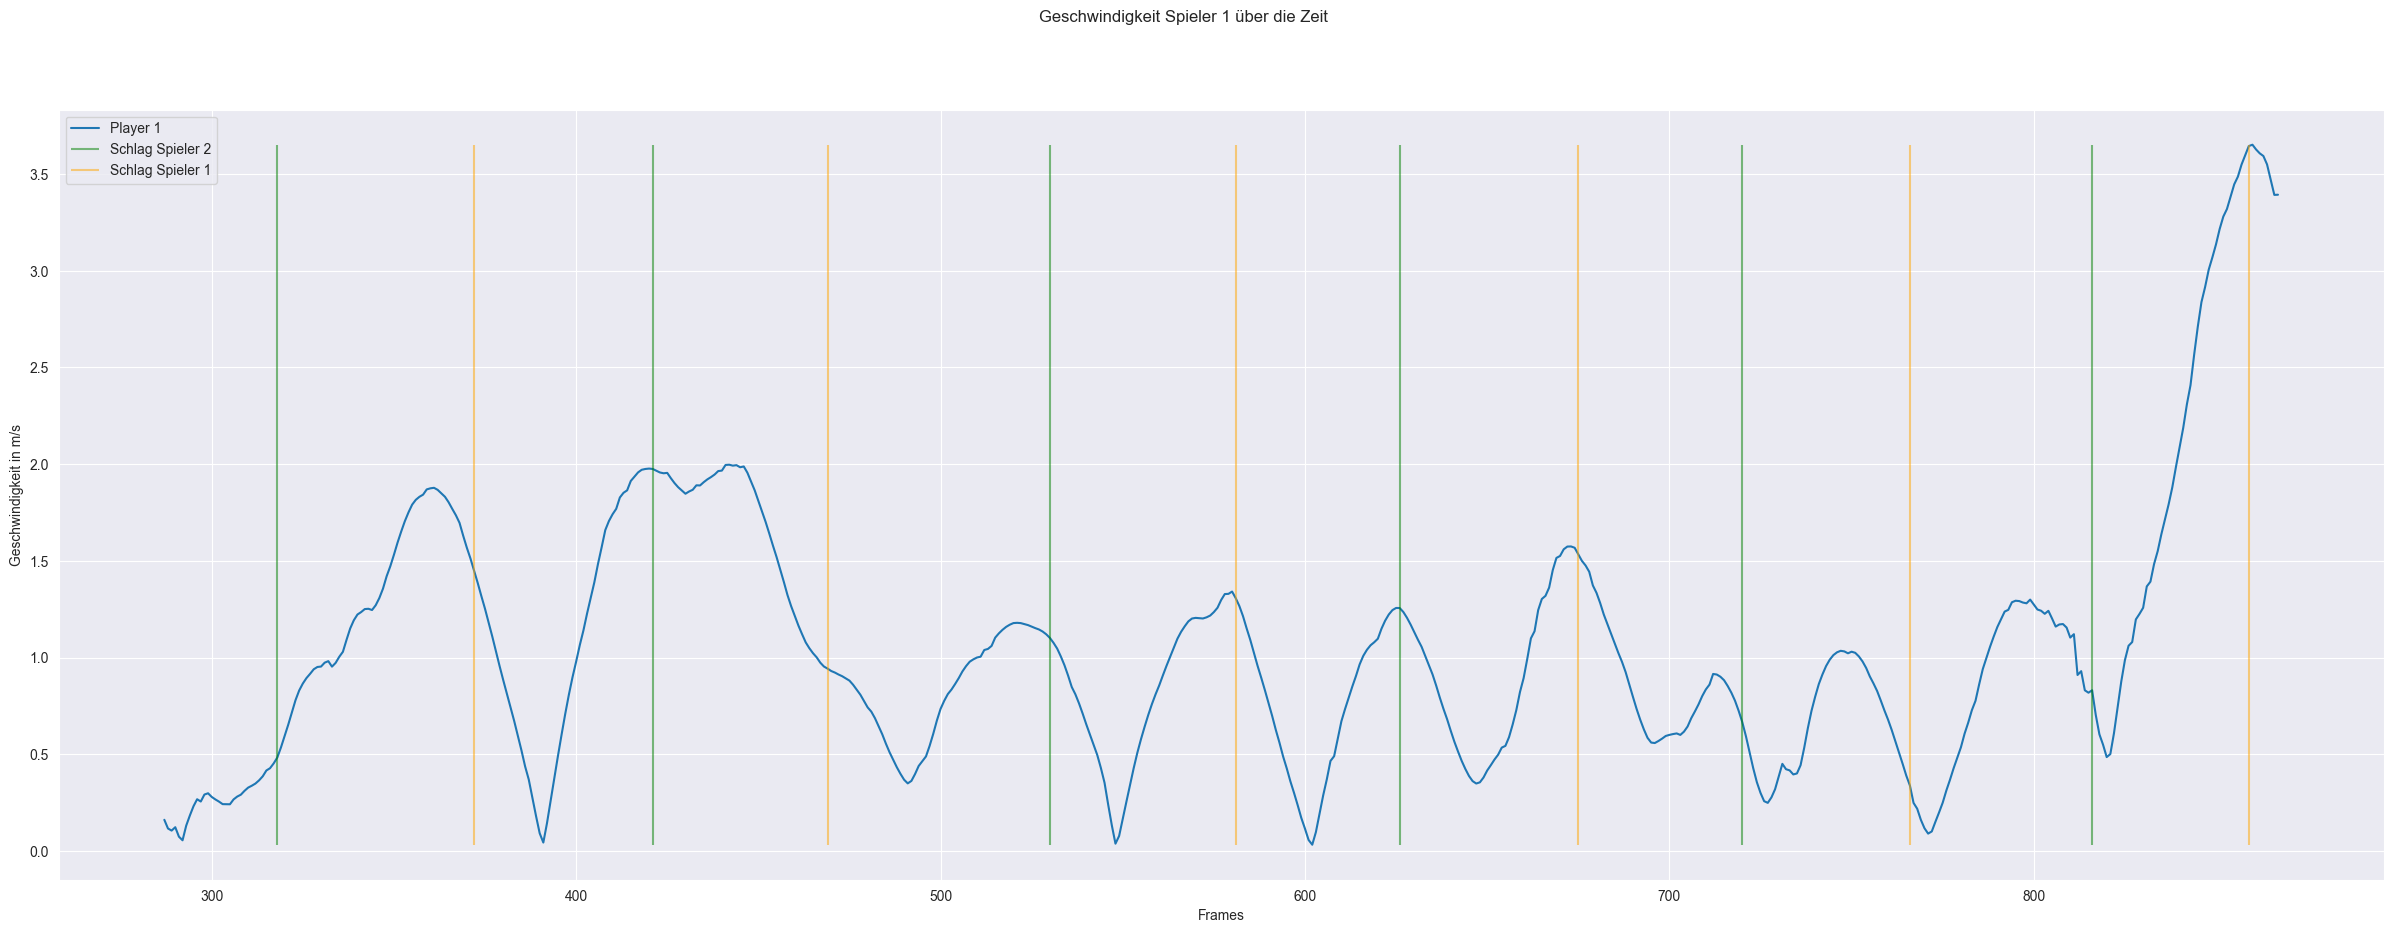

In [373]:
plt.figure(figsize=(30, 10))
plt.suptitle("Geschwindigkeit Spieler 1 über die Zeit", fontsize=12)
plt.plot(frame_1000["frame"], frame_1000["geschwindigkeit_p1"], label="Player 1")
plt.xlabel("Frames")
plt.ylabel("Geschwindigkeit in m/s")
plt.vlines(frame_1000.loc[(df['Schlag_p2'] == "Fronthand") | (df['Schlag_p2'] == "Backhand")]["frame"], ymin=frame_1000["geschwindigkeit_p1"].min(), ymax=frame_1000["geschwindigkeit_p1"].max(), color="green", alpha=0.5,label="Schlag Spieler 2")

plt.vlines(frame_1000.loc[(df['Schlag_p1'] == "Fronthand") | (df['Schlag_p1'] == "Backhand")]["frame"] , ymin=frame_1000["geschwindigkeit_p1"].min(), ymax=frame_1000["geschwindigkeit_p1"].max(), color="orange", label="Schlag Spieler 1", alpha=0.5)

plt.legend()
plt.show()

Man sieht, wie der Spieler 1 nach einem Schlag von Spieler 2 (rot und grün)beginnt zu rennen. Higegen wenn er selbst schlägt (schwarz) ist die Geschwindigkeit am abnehmen.

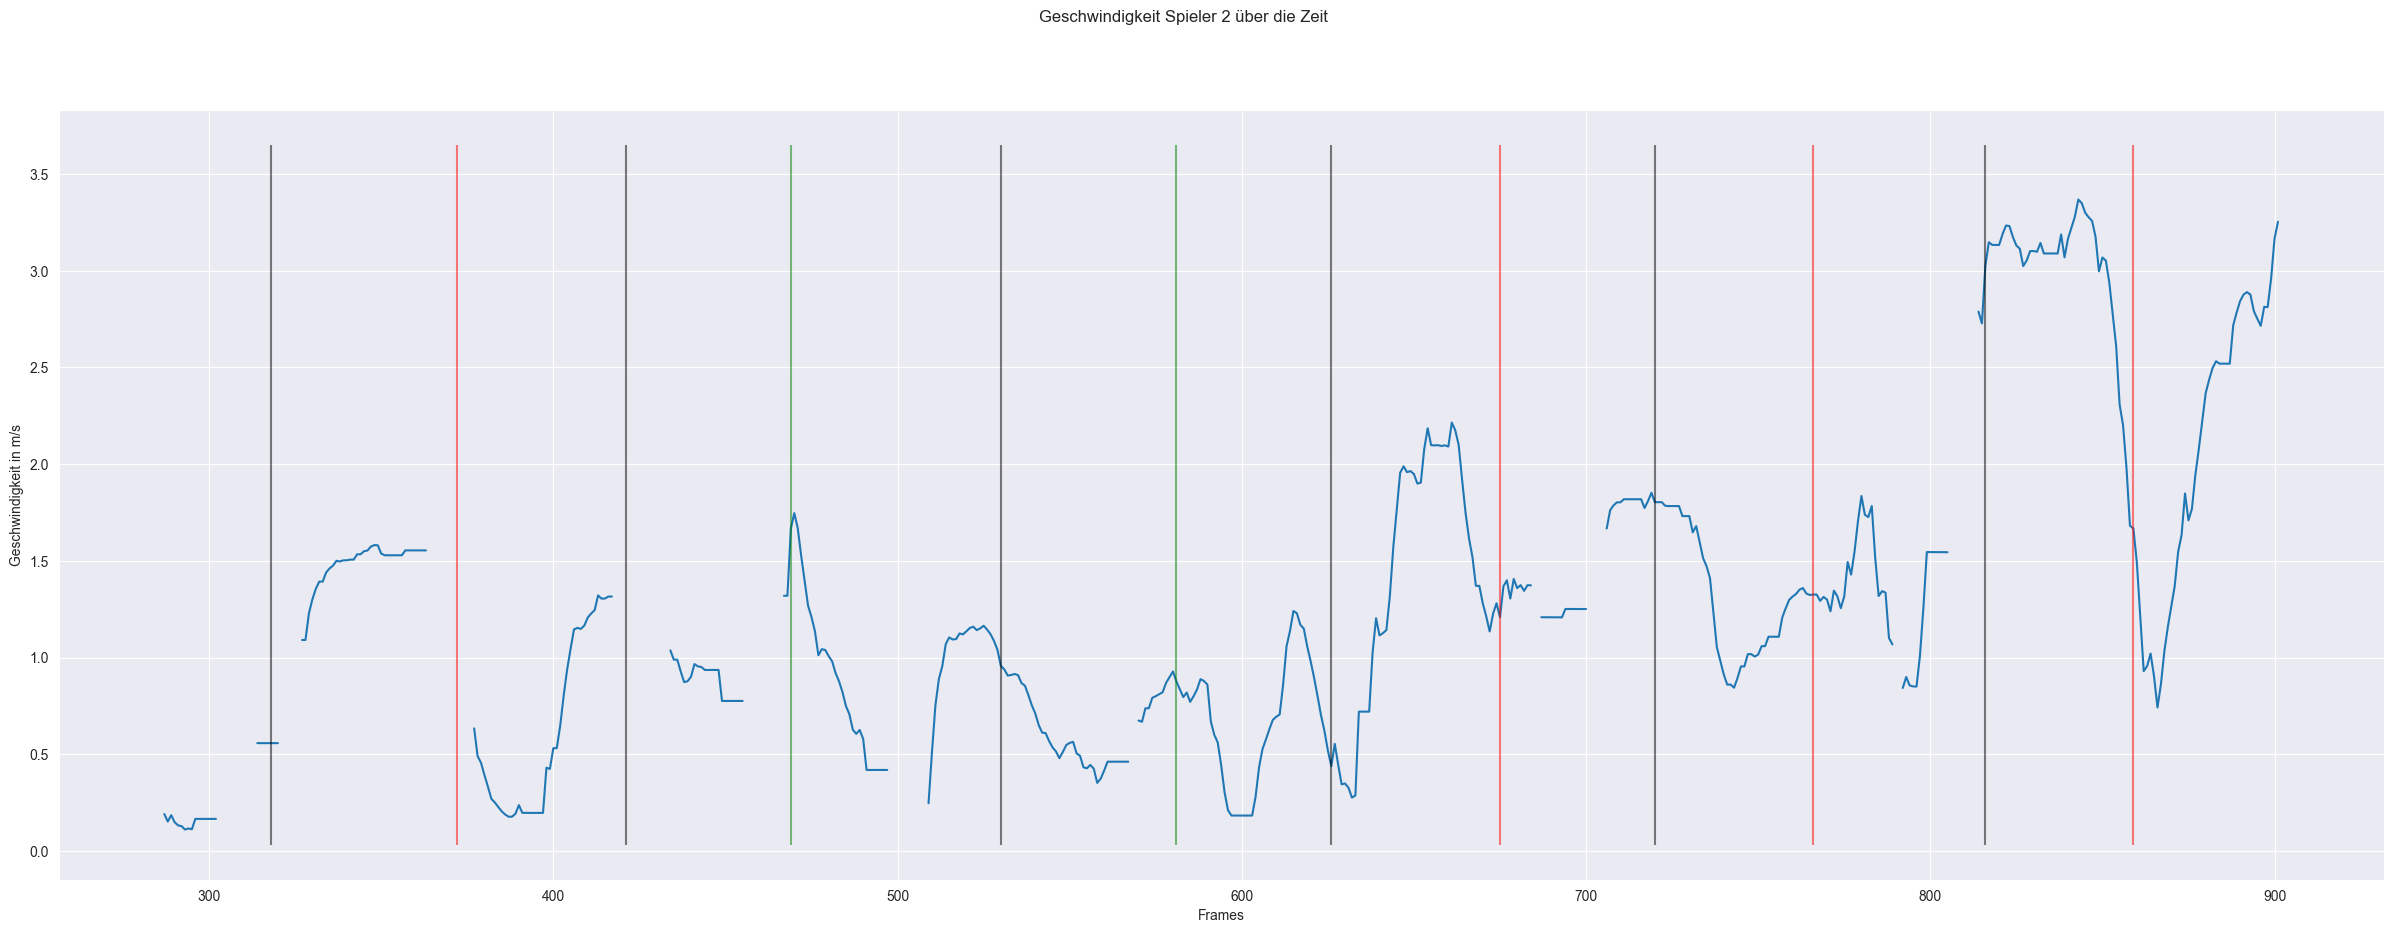

In [374]:
plt.figure(figsize=(30, 10))
plt.suptitle("Geschwindigkeit Spieler 2 über die Zeit", fontsize=12)
plt.plot(frame_1000["frame"], frame_1000["geschwindigkeit_p2"], label="Player 2")
plt.xlabel("Frames")
plt.ylabel("Geschwindigkeit in m/s")
plt.vlines(frame_1000.loc[df['Schlag_p1'] == "Fronthand"]["frame"], ymin=frame_1000["geschwindigkeit_p1"].min(), ymax=frame_1000["geschwindigkeit_p1"].max(), color="red", alpha=0.5)
plt.vlines(frame_1000.loc[df['Schlag_p1'] == "Backhand"]["frame"], ymin=frame_1000["geschwindigkeit_p1"].min(), ymax=frame_1000["geschwindigkeit_p1"].max(), color="green",  alpha=0.5)

plt.vlines(frame_1000.loc[(df['Schlag_p2'] == "Fronthand") | (df['Schlag_p2'] == "Backhand")]["frame"] , ymin=frame_1000["geschwindigkeit_p1"].min(), ymax=frame_1000["geschwindigkeit_p1"].max(), color="black", label="Anschlag Spieler 1", alpha=0.5)


plt.show()

Deutlich zu sehen ist, wie die Kamera mühe hat den Spieler 2 zu tracken. Trotzdem sieht man, wenn Spieler 1 schlägt (rot und grün) ist Spieler 2 vielmals schon am rennen. Wenn Spieler 2 schlägt (schwarz) ist die Geschwindigkeit am abnehmen wie bei Spieler 2

weitere untersuchungen der Reaktion gibt es nach der Dekompensation der Geschindigkeiten.

### Spieler positionierung

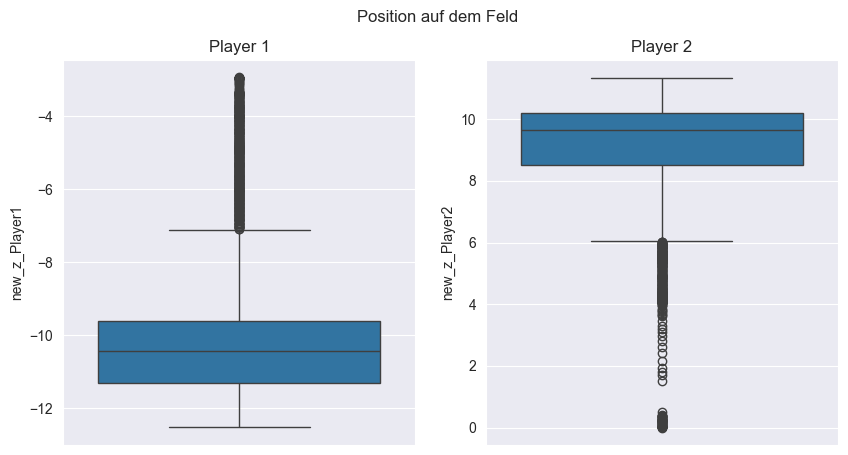

In [375]:
plt.figure(figsize=(10, 5))
plt.suptitle("Position auf dem Feld", fontsize=12)
plt.subplot(121)
plt.title("Player 1")
sns.boxplot(df, y="new_z_Player1")
plt.subplot(122)
plt.title("Player 2")
sns.boxplot(df, y="new_z_Player2")
plt.show()

### Der Spieler steht breiter während er in ruhe ist

Die These ist das man sieht mit der breite wann der Spieler einen Splitstep macht. Dazu schauen wir uns die Breite der Spieler an.

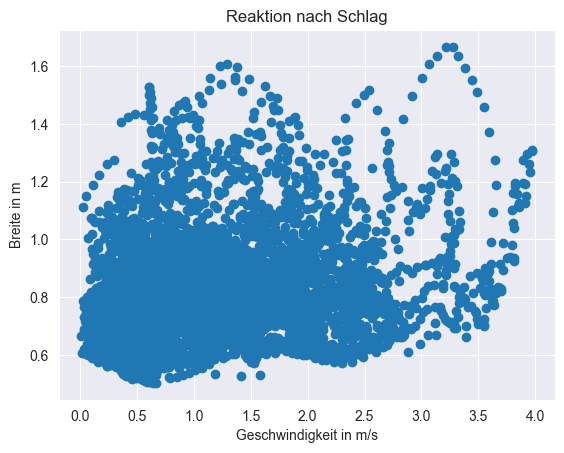

In [376]:
plt.scatter(df["geschwindigkeit_p1"], df["width_Player1"])
plt.title("Reaktion nach Schlag")
plt.xlabel("Geschwindigkeit in m/s")
plt.ylabel("Breite in m")
plt.show()

Da die Breite von Spieler 1 sicher besser ist, wurde nur auf Spieler 1 analysiert. Es scheint aber leider keine Korrelation zu geben. Wahrsscheinlich weil sich der Spieler bei hohen Geschwindigkeiten mehr streckt um an den Ball zu kommen.

### Spieler position nach Schlag des Gegners

Erster Ansatz ist der Vergleich der Zonen

In [ ]:
left_p1 = df.loc[df["pos_p1"] == "Links"]

C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


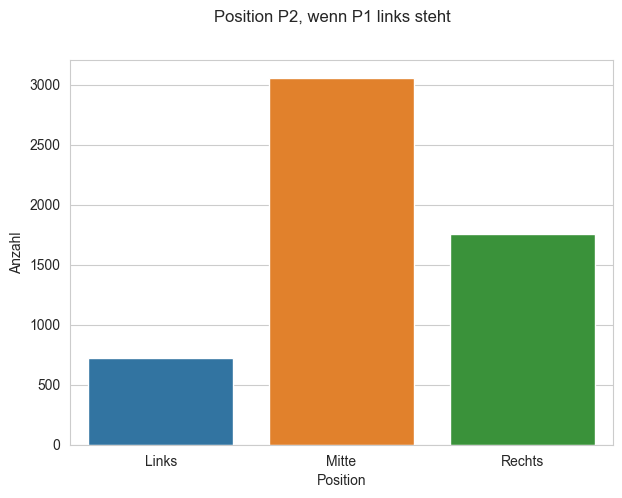

In [498]:
plt.figure(figsize=(7, 5))
plt.suptitle("Position P2, wenn P1 links steht", fontsize=12)
sns.countplot(x=df["pos_p2"])
plt.xlabel("Position")
plt.ylabel("Anzahl")
plt.show()


Der Graph sagt leider nicht so viel aus wir probieren die Position der Spieler nach dem Schlag des Gegners zu vergleichen.

Unsere These ist es das die Spieler einen unterschied zeigen in welchen Winkel sie zum Gegenspieler einnehmen wenn dieser weiter aussen steht. Dazu schauen wir uns die Position der Spieler nach dem Schlag des Gegners an.

In [377]:
p2_schlag =df.loc[(df["Schlag_p2"] == "Anschlag") | (df["Schlag_p2"] == "Fronthand") | (df["Schlag_p2"] == "Backhand")][["new_x_Player1", "new_x_Player2", "new_z_Player1","new_z_Player2"]]

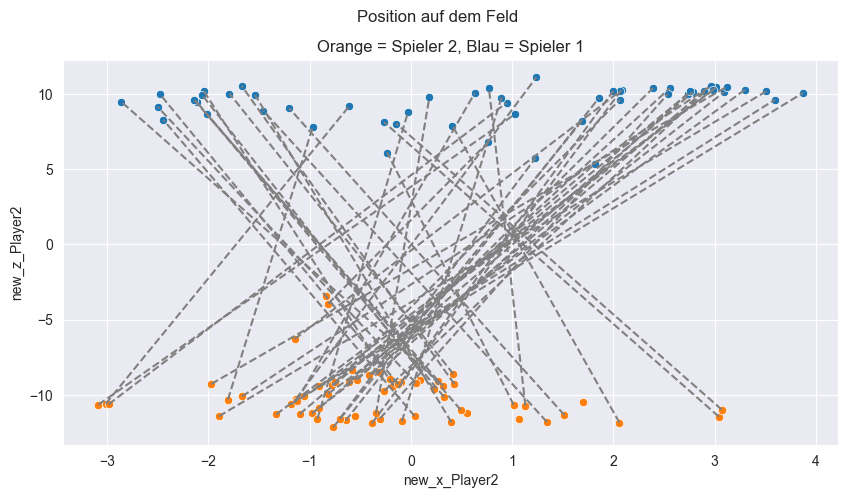

In [378]:
plt.figure(figsize=(10, 5))
plt.suptitle("Position auf dem Feld", fontsize=12)
plt.title("Orange = Spieler 2, Blau = Spieler 1")
sns.scatterplot(x="new_x_Player2", y="new_z_Player2", data=p2_schlag)
sns.scatterplot(x="new_x_Player1", y="new_z_Player1", data=p2_schlag)
# Verbindung der Punkte in derselben Zeile
for i in range(len(p2_schlag)):
    plt.plot([p2_schlag.iloc[i]['new_x_Player1'], p2_schlag.iloc[i]['new_x_Player2']],
             [p2_schlag.iloc[i]['new_z_Player1'], p2_schlag.iloc[i]['new_z_Player2']], 
             color='gray', linestyle='--')

plt.show()

Wir sehen hier das wenn Spieler 2 schlägt, und etwas weiter aussen steht, Spieler 1 sich weiter nach aussen bewegt.

In [379]:
# Winkelberechnung für jede Zeile und Hinzufügen zur DataFrame
p2_schlag['winkel'] = p2_schlag.apply(calculate_angle, axis=1)

In [380]:
p1_schlag =df.loc[(df["Schlag_p1"] == "Anschlag") | (df["Schlag_p1"] == "Fronthand") | (df["Schlag_p1"] == "Backhand")][["new_x_Player1", "new_x_Player2", "new_z_Player1","new_z_Player2"]]
# Winkelberechnung für jede Zeile und Hinzufügen zur DataFrame
p1_schlag['winkel'] = p1_schlag.apply(calculate_angle, axis=1)

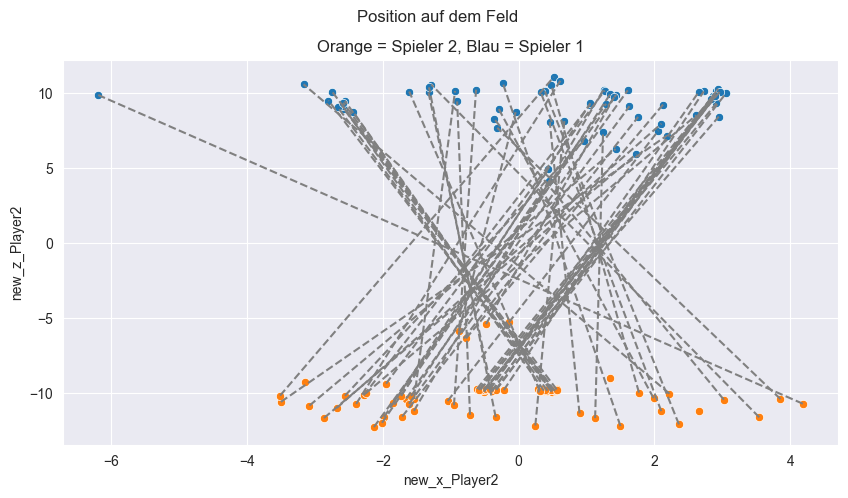

In [381]:
plt.figure(figsize=(10, 5))
plt.suptitle("Position auf dem Feld", fontsize=12)
plt.title("Orange = Spieler 2, Blau = Spieler 1")
sns.scatterplot(x="new_x_Player2", y="new_z_Player2", data=p1_schlag)
sns.scatterplot(x="new_x_Player1", y="new_z_Player1", data=p1_schlag)
# Verbindung der Punkte in derselben Zeile
for i in range(len(p1_schlag)):
    plt.plot([p1_schlag.iloc[i]['new_x_Player1'], p1_schlag.iloc[i]['new_x_Player2']],
             [p1_schlag.iloc[i]['new_z_Player1'], p1_schlag.iloc[i]['new_z_Player2']], 
             color='gray', linestyle='--')

plt.show()

Auch wenn Spieler 1 schlägt, und etwas weiter aussen steht, bewegt sich Spieler 2 weiter nach aussen.

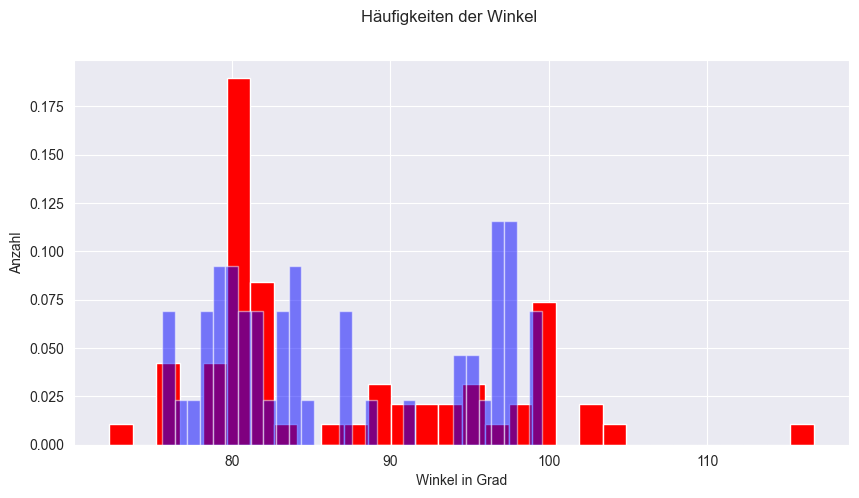

In [382]:
plt.figure(figsize=(10, 5))
plt.suptitle("Häufigkeiten der Winkel", fontsize=12)
plt.hist(p1_schlag["winkel"], bins=30, color="red", density=True)
plt.hist(p2_schlag["winkel"], bins=30, color="blue", alpha=0.5, density=True)
plt.xlabel("Winkel in Grad")
plt.ylabel("Anzahl")
plt.show()

Wenn wir die Winkel der beiden Spieler vergleichen, sehen wir das die Winkel der Spieler sehr ähnlich sind. Um wirklich aber eine Aussage zu machen vergleichen wir den einfluss der Position auf den Winkel.

In [383]:
p1_schlag["abs_winkel"] = np.where(p1_schlag["winkel"] < 90 , p1_schlag["winkel"], 180 - p1_schlag["winkel"])
p2_schlag["abs_winkel"] = np.where(p2_schlag["winkel"] < 90 , p2_schlag["winkel"], 180 - p2_schlag["winkel"])

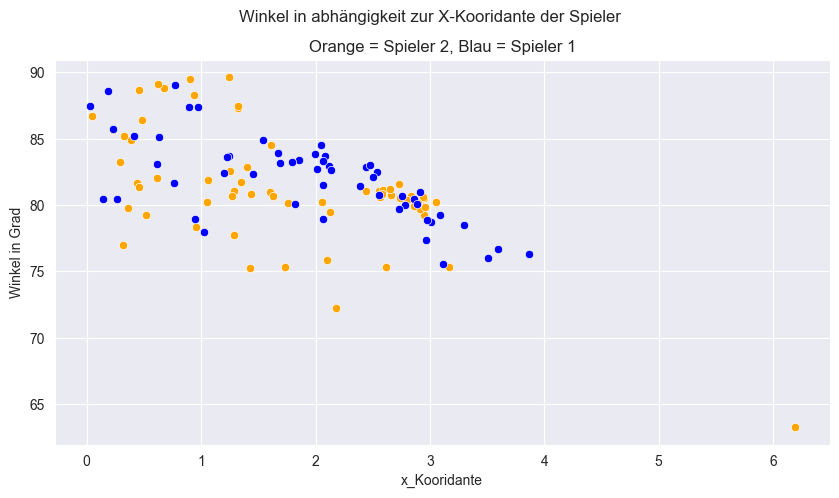

In [384]:
plt.figure(figsize=(10, 5))
plt.suptitle("Winkel in abhängigkeit zur X-Kooridante der Spieler", fontsize=12)
plt.title("Orange = Spieler 2, Blau = Spieler 1")
sns.scatterplot(x=abs(p1_schlag["new_x_Player2"]), y="abs_winkel", data=p1_schlag, color="orange")
sns.scatterplot(x=abs(p2_schlag["new_x_Player2"]), y="abs_winkel", data=p2_schlag, color="blue")
plt.xlabel("x_Kooridante")
plt.ylabel("Winkel in Grad")
plt.show()

Wir sehen nun sicher einen Trend der beiden Spieler. Je weiter aussen der Spieler steht, desto stumpfer ist der Winkel. Spieler 2 scheint eher einen stumpferen Winkel zu haben als Spieler 1. Was ein Grundsätzlich ein Vorteil ist, da der Ball weiter nach aussen gespielt werden kann.

## Analyse der Geschwindigkeit

In diesem Abschnitt wird untersucht, ob man die Geschidigkeit der Spieler auch mit klassischen Werkzeugen der Zeitreihen Analyse untersuchen kann. KOnkret geht es einmal um das Dekompensieren der Zeitreihe in Trend, Saisonalität und Residuen umDanach eine Kreuzkorrelation der SPieler zu machen. Folgende Thesen kann man durch die Dekopensoierung untersuchern:

1. Werden die Spieler im Verlauf des Spiels lanngsamer? (Trendanalyse)
2. Gibt es einen wiederkerehner Muster bei der Geschwindigkeit der Spieler? (Muster) Wenn ja, was genau bedeutet das im Bezug mit dem Spiel
3. Gibt es ine verzögerung bei der Geschwindigkeit der Spieler? (Kreuzkorrelation)

um die Analyse etwas einfacher zu gestalten, wird der Dataframe neu vorbereitet. Die Analyse wird etwas erschwert, da die Kamerea den zweiten spiler öfters nicht erkennt.

#### Data Frame vorbereiten

Um eine Sinvolle Achsenbeschriftungen zu haben, wird die Spalte [s] hinzugeügt, die die vergangenen Sekunden seit dem ersten Anspiel beinhaltet. Diese Spalte wird dann als DateTime Objekt in den Index gespeichert, wobei man den Datum ignorieren kann. Den es war technisch nicht möglich, nur den  TImestamp zu speichern und diesen auch für die einzelnen Analysen und PLotz zu benutzten.

Abschliesend stellen wir die einzelnen Geschindikeiten der Spieler mit aktiven und inaktiven Phasen.

In [385]:
def frames_to_s(frame, start_frame=287, fps=30):
    seconds = (frame - start_frame) / fps
    return seconds

data['s'] = data['frame'].apply(frames_to_s)

In [386]:
def frames_to_timestamp(frame, start_frame=287, fps=30):
    seconds = (frame - start_frame) / fps
    timestamp = datetime(1, 1, 1) + pd.Timedelta(seconds=seconds)
    return timestamp.strftime('%H:%M:%S.%f')

data['timestamp'] = data['frame'].apply(frames_to_timestamp, args=(287, 30))

timestamp_format = '%H:%M:%S.%f'

data['timestamp'] = pd.to_datetime(data['timestamp'], format=timestamp_format)
data = data.set_index('timestamp')

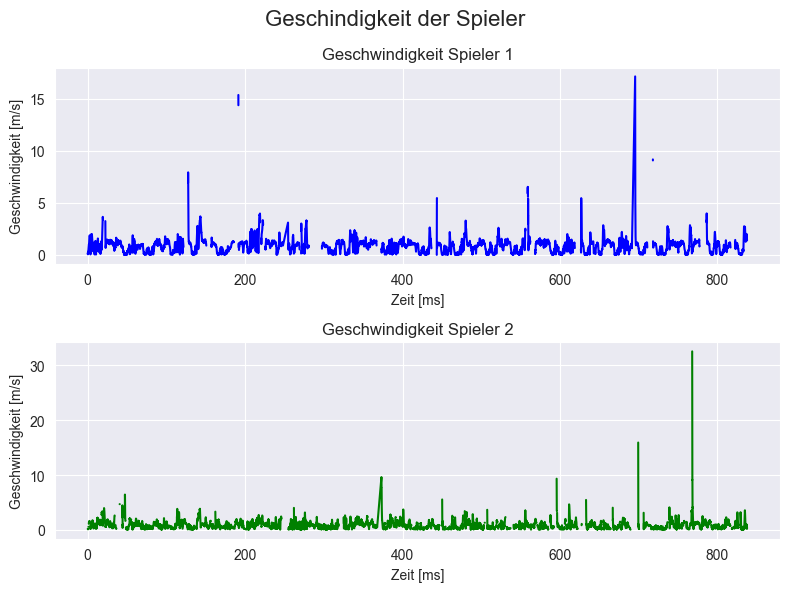

In [387]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Zeichnen der Geschwindigkeit für Spieler 1 im ersten Subplot
axs[0].plot(data['s'], data['geschwindigkeit_p1'], color='blue')
axs[0].set_title('Geschwindigkeit Spieler 1')
axs[0].set_xlabel('Zeit [ms]')
axs[0].set_ylabel('Geschwindigkeit [m/s]')

# Zeichnen der Geschwindigkeit für Spieler 2 im zweiten Subplot
axs[1].plot(data['s'], data['geschwindigkeit_p2'], color='green')
axs[1].set_title('Geschwindigkeit Spieler 2')
axs[1].set_xlabel('Zeit [ms]')
axs[1].set_ylabel('Geschwindigkeit [m/s]')

plt.suptitle('Geschindigkeit der Spieler', fontsize = 16)
plt.tight_layout()
plt.show()

Im oberen Plot kann man die geschwindigkeit der Spieler erkenne. Problematisch für die Zeitreihenanalys eist wie bereits erwähnt die einzelnen Lücken. einzelnen Aussreiser sind wieder erkennbar, weshalb MAN wieder ein Rollingmean auf die unrealistischen Aussreiser machen muss. Die neuen hohenwerte, können aber auch beim rauslaufen des Feldes während einer inaktiven Phase um den Ball einzusammeln. Dies untersuchen wir im nächsten Plot:

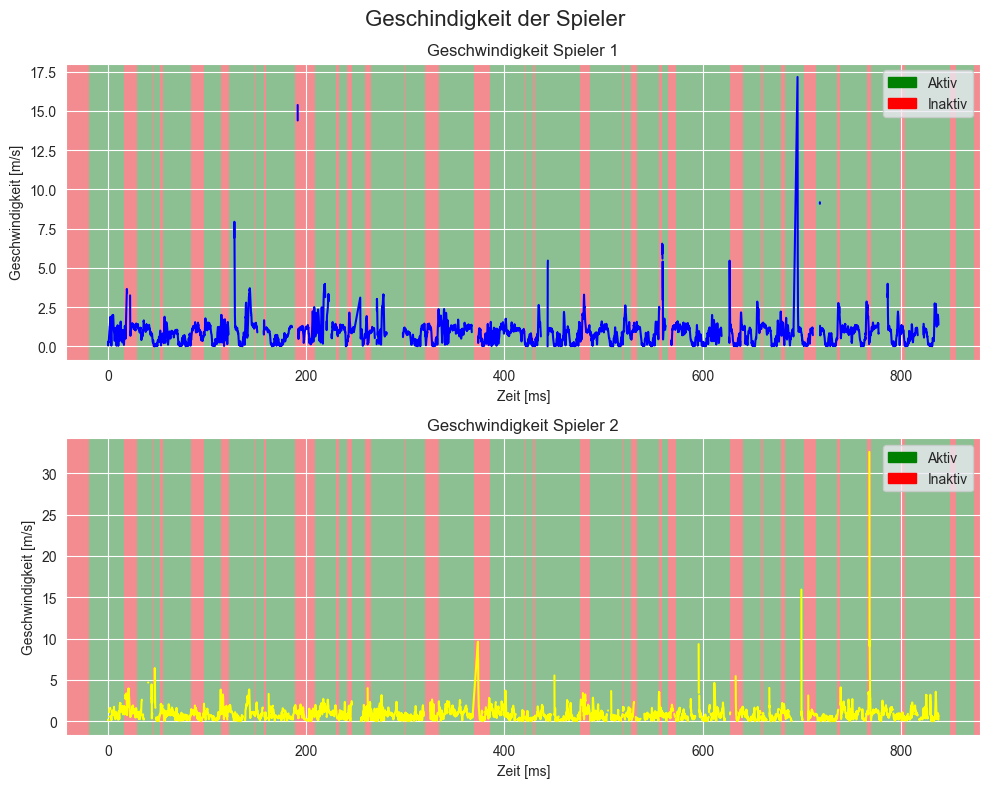

In [388]:
def AktivInaktivPlot(title , gesp1, gesp2):
    cmap = ListedColormap(['green', 'red'])
    # Hinzufügen von benutzerdefinierten Patches für die Legende
    aktiver_patch = mpatches.Patch(color='green', label='Aktiv')
    inaktiver_patch = mpatches.Patch(color='red', label='Inaktiv')
    data['Status_color'] = data['Status'].map({'Aktiv': 1, 'Inaktiv': 0})
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # Zeichnen der Geschwindigkeit Spieler 1
    axs[0].plot(data['s'], data[gesp1], color='blue')
    axs[0].pcolorfast(axs[0].get_xlim(), axs[0].get_ylim(),
                  data['Status_color'].values[np.newaxis],
                  cmap=cmap, alpha=0.4)
    axs[0].legend(handles=[aktiver_patch, inaktiver_patch])
    axs[0].set_title('Geschwindigkeit Spieler 1')
    axs[0].set_xlabel('Zeit [ms]')
    axs[0].set_ylabel('Geschwindigkeit [m/s]')

    # Zeichnen der Geschwindigkeit  Spieler 2
    axs[1].plot(data['s'], data[gesp2], color='yellow')
    axs[1].set_title('Geschwindigkeit Spieler 2')
    axs[1].set_xlabel('Zeit [ms]')
    axs[1].set_ylabel('Geschwindigkeit [m/s]')
    axs[1].pcolorfast(axs[1].get_xlim(), axs[1].get_ylim(),
                  data['Status_color'].values[np.newaxis],
                  cmap=cmap, alpha=0.4)
    axs[1].legend(handles=[aktiver_patch, inaktiver_patch])

    plt.suptitle(title, fontsize = 16)
    plt.tight_layout()
    plt.show()

AktivInaktivPlot('Geschindigkeit der Spieler','geschwindigkeit_p1','geschwindigkeit_p2')

Im oberen Plot kann man erkennen, dass einzelne hohe Geschndigkeiten in der inaktive Zeit passiert. Um die richtigen Geschwindigkeitn nicht zu verfäschlen, weden diese zuerst entfernt. Das Ziel ist es vorallem den kleinen Fleckvon Spielr 1 bei knapp 200 ms und 15 m/s und die ganz hohe spitze bei Spieler 2. Um das zu erreichen, setzte ich alle Geschwindigkeiten die höher als 5,5 m/s während einer inakriven Phase auf 2.5 m/s. Der Wert darf auch nicht zu tief gesetzt werden, um mögliches Abremsen abzuschneiden.

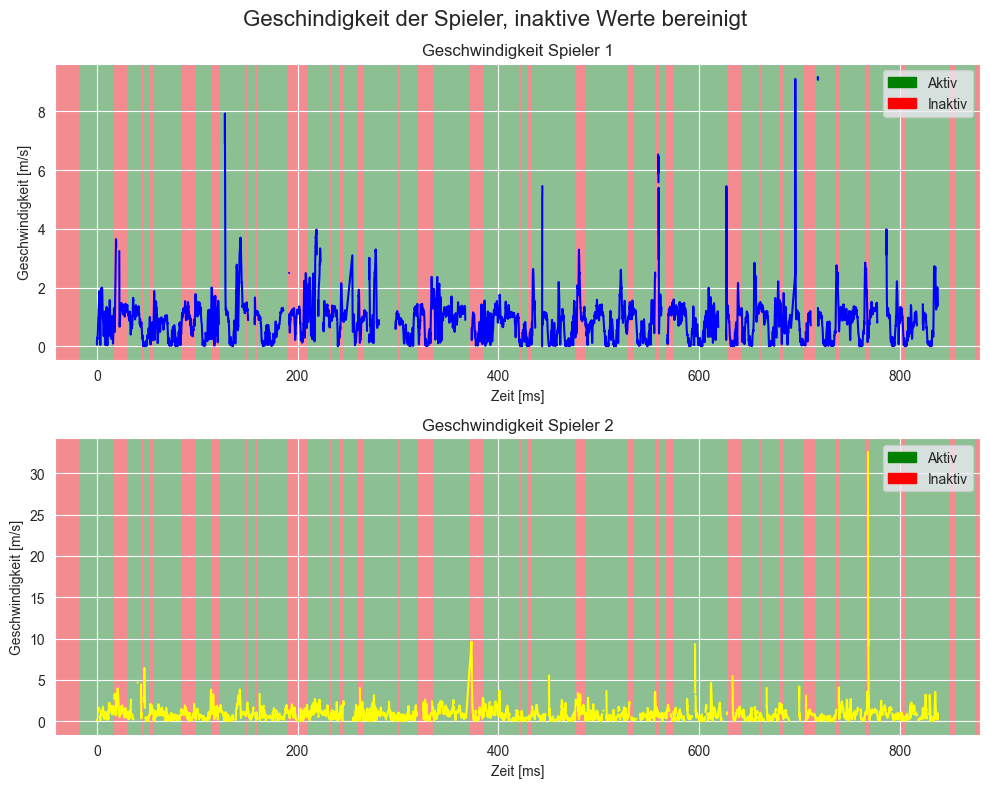

In [389]:
data.loc[(data['geschwindigkeit_p1'] > 10) & (data['Status'] == 'Inaktiv'), 'geschwindigkeit_p1'] = 2.5
data.loc[(data['geschwindigkeit_p2'] > 10) & (data['Status'] == 'Inaktiv'), 'geschwindigkeit_p2'] = 2.5

AktivInaktivPlot('Geschindigkeit der Spieler, inaktive Werte bereinigt','geschwindigkeit_p1','geschwindigkeit_p2')

Durch die Reinigung der einzelnen Spitzenwerte sieht die Geschwindigkeit von Spieler 1 sehr realistisch aus. Spieler 2 hat leider immernoch einen sehr hohen unrealistischen Aussreiser von 30 ms pro Sekunde. Diese entfernen wir mit dem gleichen Ansatz mit der Berechnung von den vergangenen Positione.

In [390]:
def correctedSpeed(data, ms, spieler, gscolumn):
    Columns = [f"new_x_Player{spieler}",
               f"new_y_Player{spieler}",
               f"new_z_Player{spieler}",
               gscolumn]

    spieler_data = data[Columns].copy()

    # Identifying incorrect speed values
    wrong_vek = spieler_data.loc[spieler_data[gscolumn] > ms, Columns]

    if not wrong_vek.empty:

        first_row = wrong_vek.iloc[0]
        last_row = wrong_vek.iloc[-1]

        # Berchnen der Differnzen von den Werten
        vect = last_row.values - first_row.values

        # Berchnen der Distanzen mit auslassen von Geschwindigkeit
        dist = np.sqrt(np.sum(vect[:3] ** 2))

        # Berechnen der Zetdiff
        time_diff = (last_row.name - first_row.name).total_seconds()


        speed = dist / time_diff
        spieler_data.loc[spieler_data[gscolumn] > ms, gscolumn] = speed

    # Merge the corrected column with the original DataFrame
    data[f'{gscolumn}_k'] = spieler_data[gscolumn]

    return data

data = correctedSpeed(data, 5, 2, "geschwindigkeit_p2")
data = correctedSpeed(data, 5, 1, "geschwindigkeit_p1")

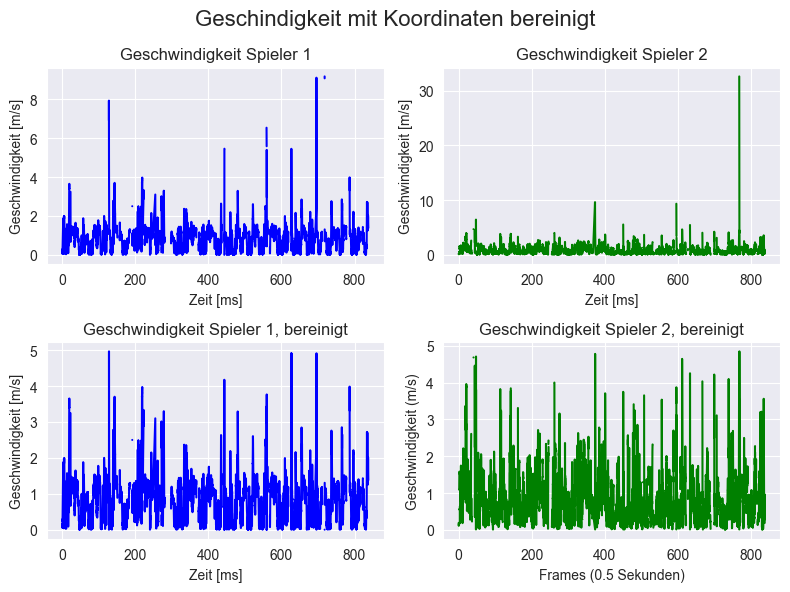

In [391]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0,0].plot(data['s'], data['geschwindigkeit_p1'], color='blue')
axs[0,0].set_title('Geschwindigkeit Spieler 1')
axs[0,0].set_xlabel('Zeit [ms]')
axs[0,0].set_ylabel('Geschwindigkeit [m/s]')

axs[1,0].plot(data['s'], data['geschwindigkeit_p1_k'], color='blue')
axs[1,0].set_title('Geschwindigkeit Spieler 1, bereinigt')
axs[1,0].set_xlabel('Zeit [ms]')
axs[1,0].set_ylabel('Geschwindigkeit [m/s]')

axs[0,1].plot(data['s'], data['geschwindigkeit_p2'], color='green')
axs[0,1].set_title('Geschwindigkeit Spieler 2')
axs[0,1].set_xlabel('Zeit [ms]')
axs[0,1].set_ylabel('Geschwindigkeit [m/s]')


axs[1,1].plot(data['s'], data['geschwindigkeit_p2_k'], color='green')
axs[1,1].set_title('Geschwindigkeit Spieler 2, bereinigt')
axs[1,1].set_xlabel('Frames (0.5 Sekunden)')
axs[1,1].set_ylabel('Geschwindigkeit (m/s)')
plt.suptitle('Geschindigkeit mit Koordinaten bereinigt', fontsize = 16)
plt.tight_layout()
plt.show()

In diesem Plot kann erkennen. dass die Bereinugung der Daten gut geklappt hat. Bei der Umsetzung der Funktion wurde noch ergänz, dass es die Zeitdifferenz mit dem Index berechnet. Man kann noch die einzelnen Lücken erkennen, die wir einfachheitshalber mit linearen interpolation fühlen können.

Wir können erkennen das die Imlemantion erfolgreich efunktioniert hat. Es gibt aber immernoch fehlende geschwindigkeiten, dort wo der Spieler nicht erkannt werden konnte.

#### Interpolieren

Um die fehlende Werte afzugüllen,verwenden wir eine einfache lineare Interpolation. Zuvor entfernen wir aber den einzelnen


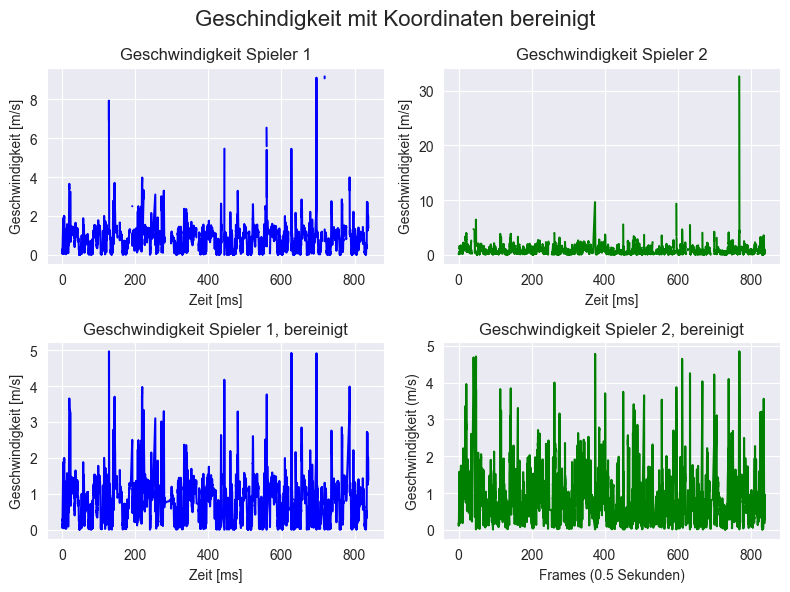

In [392]:
data["geschwindigkeit_p1_k_ip"] = data["geschwindigkeit_p1_k"].interpolate()
data["geschwindigkeit_p2_k_ip"] = data["geschwindigkeit_p2_k"].interpolate()

fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0,0].plot(data['s'], data['geschwindigkeit_p1'], color='blue')
axs[0,0].set_title('Geschwindigkeit Spieler 1')
axs[0,0].set_xlabel('Zeit [ms]')
axs[0,0].set_ylabel('Geschwindigkeit [m/s]')

axs[1,0].plot(data['s'], data['geschwindigkeit_p1_k_ip'], color='blue')
axs[1,0].set_title('Geschwindigkeit Spieler 1, bereinigt')
axs[1,0].set_xlabel('Zeit [ms]')
axs[1,0].set_ylabel('Geschwindigkeit [m/s]')

axs[0,1].plot(data['s'], data['geschwindigkeit_p2'], color='green')
axs[0,1].set_title('Geschwindigkeit Spieler 2')
axs[0,1].set_xlabel('Zeit [ms]')
axs[0,1].set_ylabel('Geschwindigkeit [m/s]')


axs[1,1].plot(data['s'], data['geschwindigkeit_p2_k_ip'], color='green')
axs[1,1].set_title('Geschwindigkeit Spieler 2, bereinigt')
axs[1,1].set_xlabel('Frames (0.5 Sekunden)')
axs[1,1].set_ylabel('Geschwindigkeit (m/s)')
plt.suptitle('Geschindigkeit mit Koordinaten bereinigt', fontsize = 16)
plt.tight_layout()
plt.show()

Die Daten sehen nun für eine Dekompenisrung der Elemente ready aus.

#### Zeitreihen Dekompensiern

Bevor wir mit der Dekompensierung loslegen, plotten wir die PCAF und ACF der zwei Geschwindigkeiten. ZUvor gruppeieren wir die Geschwindigkeiten mit mean auf 0.5 Sekunden um, umd die Lags besser interpretieren zu können. Dafür erstellen wir einene neuen DF nur mit den Geschwindigkeiten,

In [393]:
data_s = data[['geschwindigkeit_p1_k_ip', 'geschwindigkeit_p2_k_ip']].copy()
data_s = data_s.resample('500ms').mean()
data_s['s'] = (data_s.index - data_s.index[0]).total_seconds()
data_s = data_s.dropna()
data_s.head()

,geschwindigkeit_p1_k_ip,geschwindigkeit_p2_k_ip,s
timestamp,,,
1900-01-01 00:00:00.000,0.189139,0.151266,0.0
1900-01-01 00:00:00.500,0.315812,0.387700,0.5
1900-01-01 00:00:01.000,0.769124,0.882713,1.0
1900-01-01 00:00:01.500,1.144037,1.489932,1.5
1900-01-01 00:00:02.000,1.692294,1.547858,2.0


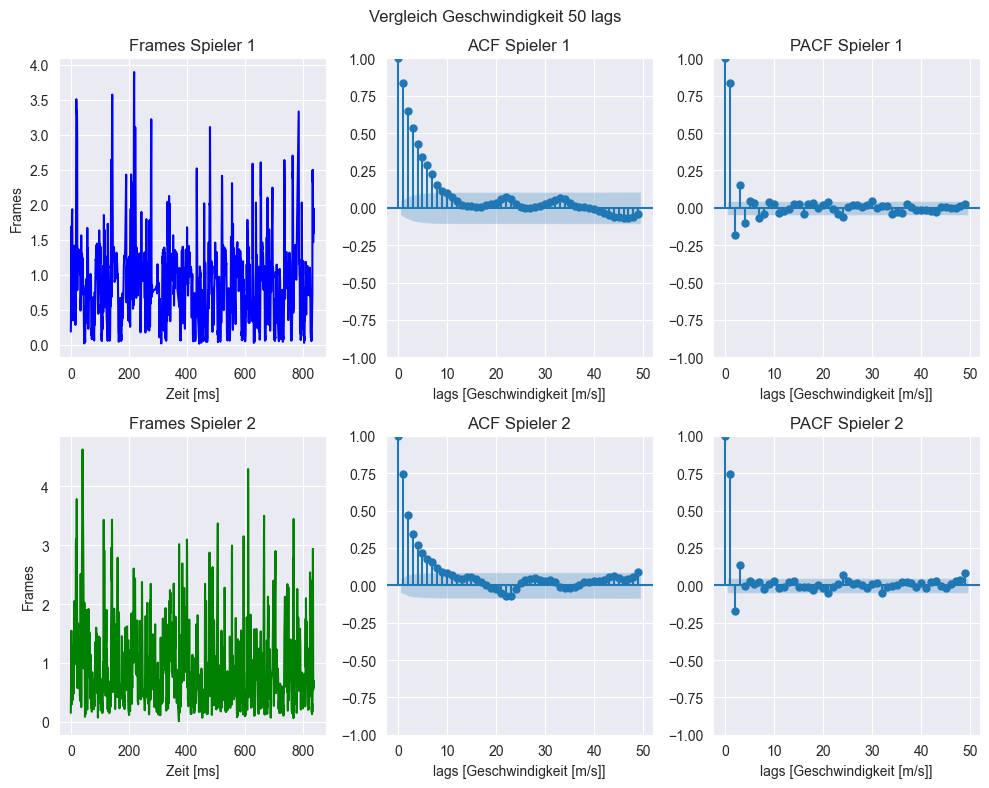

In [394]:
def acfPcafSpieler(dfs, columns, n_lags, lagstxt, ytext, titel):
    data_c = dfs[columns].copy()
    data_c_noNAs = data_c.dropna()
    geschwindigkeit_p1 = data_c_noNAs[columns[0]]
    geschwindigkeit_p2 = data_c_noNAs[columns[1]]
    time_s = data_c_noNAs['s']


    fig, axs = plt.subplots(2, 3, figsize=(10, 8))
    # Zeichnen der Geschwindigkeit für Spieler 1 im ersten Subplot
    axs[0,0].plot(time_s, geschwindigkeit_p1, color='blue')
    axs[0,0].set_title(ytext + ' Spieler 1')
    axs[0,0].set_xlabel('Zeit [ms]')
    axs[0,0].set_ylabel(ytext)

    # Zeichnen der Geschwindigkeit für Spieler 2 im zweiten Subplot
    axs[1,0].plot(time_s, geschwindigkeit_p2, color='green')
    axs[1,0].set_title(ytext +' Spieler 2')
    axs[1,0].set_xlabel('Zeit [ms]')
    axs[1,0].set_ylabel(ytext)

    # Zeichnen der ACF für Spieler 1
    plot_acf(geschwindigkeit_p1, ax=axs[0,1], lags= range(0,n_lags))
    axs[0,1].set_title('ACF Spieler 1')
    axs[0,1].set_xlabel(f'lags [{lagstxt}]')

    # Zeichnen der PACF für Spieler 1
    plot_pacf(geschwindigkeit_p1, ax=axs[0,2],lags=range(0,n_lags) )
    axs[0,2].set_title('PACF Spieler 1')
    axs[0,2].set_xlabel(f'lags [{lagstxt}]')

    # Zeichnen der ACF für Spieler 2
    plot_acf(geschwindigkeit_p2, ax=axs[1,1], lags= range(0,n_lags))
    axs[1,1].set_title('ACF Spieler 2')
    axs[1,1].set_xlabel(f'lags [{lagstxt}]')
    # Zeichnen der PACF für Spieler 2
    plot_pacf(geschwindigkeit_p2, ax=axs[1,2], lags= range(0,n_lags))
    axs[1,2].set_title('PACF Spieler 2')
    axs[1,2].set_xlabel(f'lags [{lagstxt}]')
    plt.suptitle(titel)
    plt.tight_layout()
    plt.show()

acfPcafSpieler(data_s, ['geschwindigkeit_p1_k_ip','geschwindigkeit_p2_k_ip','s'], 50,'Geschwindigkeit [m/s]', 'Frames', 'Vergleich Geschwindigkeit 50 lags' )

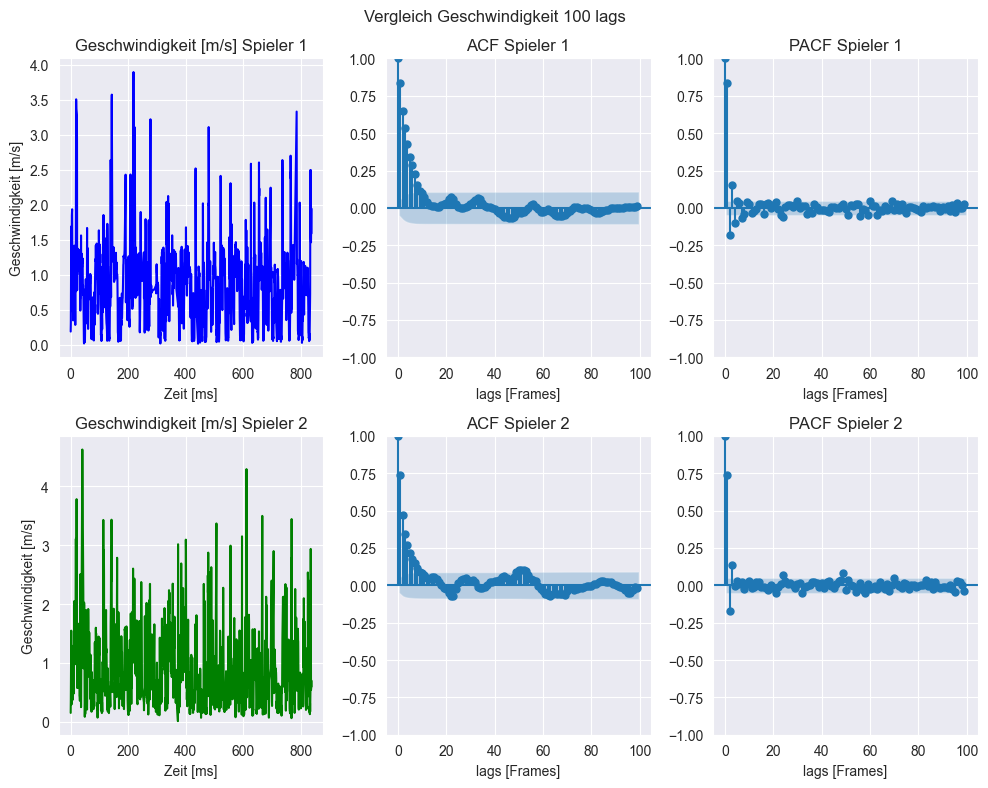

In [395]:
acfPcafSpieler(data_s, ['geschwindigkeit_p1_k_ip','geschwindigkeit_p2_k_ip','s'], 100,'Frames','Geschwindigkeit [m/s]',  'Vergleich Geschwindigkeit 100 lags' )

Dieser Plot zeigt beinhaltet sehr interessante Erkentnisse über die Geschwindigkeit der Spieler. Die absteigene Lags bei den ACF zeigt das es eine Trend Komponente hat und sehr wahrscheinlich einen wiederkehrender Muster bzw. saionaliät. Spannenderweise flacht die AFC von SPieler 2 stärker ab als Spieler 1.

Beim PCAF Plot zeigt mit den hohen ersten Lag, das der Wert $X_t$ ziemlich stark von Wert $X_{t-1}$ abhängt. Dies macht bei der Geschwindigkeit auch sinn, ist aber für mögliche Modellierungen mit Arima Modelle wichtig. Denn dies spricht für einen autoregressiven Modell erster Ordnung.

##### Zerlegung

Für die Zerlegung in einer Trend, Saisonalen und Zufall KOmponenten wird zuerst Mittels Fourier Analyse versucht die grössten Frequenzen innerhalb der Geschwindigkeit zu erkennen. Da Tennis einen doch recht rythmischen Spiel ist, habe ich sogar die Hoffnung etwas in der Fourier Analyse erkennen zu können.

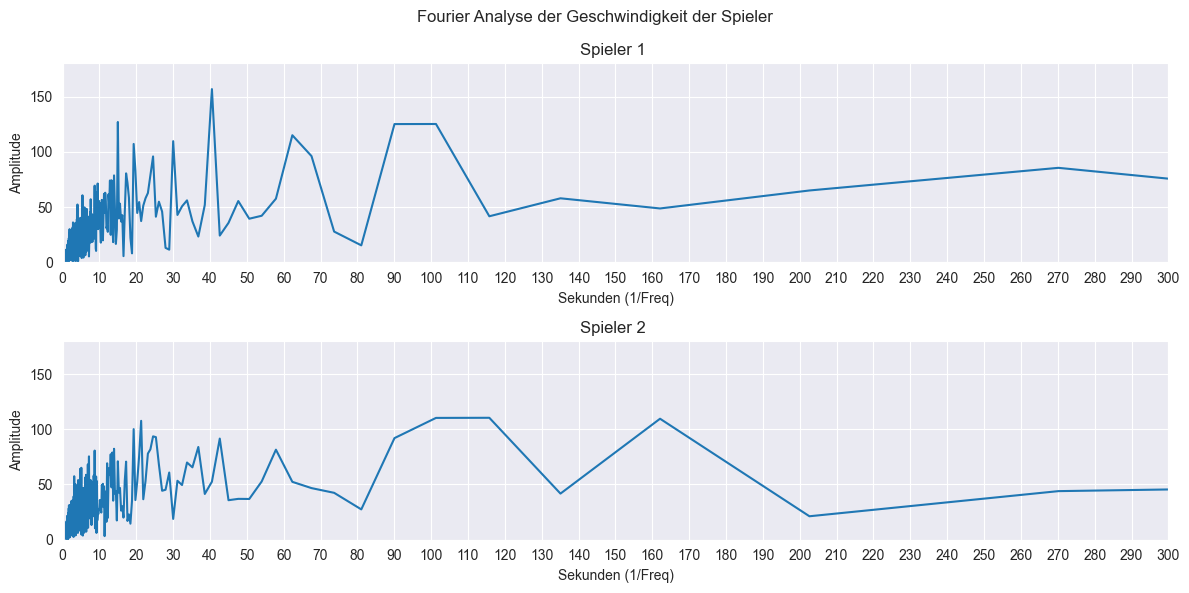

In [396]:
def fourier_analyse(df, column_names, frame_rate):
    if len(column_names) != 2:
        raise ValueError("Bitte genau zwei Spaltennamen angeben.")

    fig, axs = plt.subplots(2, 1, figsize=(12, 6))

    for i, column_name in enumerate(column_names):
        # Remove NAs
        df_fourier = df.dropna(subset=[column_name])

        # Fourier Analysis
        fft_values = np.fft.rfft(df_fourier[column_name])
        amplitudes = np.abs(fft_values)
        freqs = np.fft.rfftfreq(len(df_fourier[column_name]), d=1/2) #/2 für die richife anzahl Seq

        valid_indices = freqs > 0
        freqs = freqs[valid_indices]
        amplitudes = amplitudes[valid_indices]


        axs[i].plot(1/freqs, amplitudes)
        axs[i].set_title(f'Spieler {i+1} ')
        axs[i].set_xlabel("Sekunden (1/Freq)")
        axs[i].set_ylabel("Amplitude")
        axs[i].set_ylim(0, 180)  # Nach ersten plotten angepasst
        axs[i].set_xlim(0, 300)  # Nach ersten plotten angepasst
        axs[i].set_xticks(range(0,301,10))
    plt.suptitle('Fourier Analyse der Geschwindigkeit der Spieler')
    plt.tight_layout()
    plt.show()
fourier_analyse(data_s, ["geschwindigkeit_p1_k_ip", "geschwindigkeit_p2_k_ip"], 30)

Die Fourier ANalyse hat leider nicht so einen glasklaren Resultat geliefert. Spieler 1 hat im vergleich zu Spieler 2 einen seher hohen peak bei 40 Sekunden und allgemeine Punkte mit höheren Werte. Das könnte bedeuten, dass der Spieler 1 mehr einen wiederkehrender Bewegungsmuster als Spieler 2 hat.
Dies ermöglicht die These aufzustellen, das Spieler 2 Spieler 1 mehr rennen lässt als Spieler 1 den Spieler 2.


Bei Ca 90s gibt es einen Peak, wlecher bei beiden Vorhanden isr. Dies könnte ein Ballwechsels mit Pause sein.


In [397]:


model_p1 = STL(data_s["geschwindigkeit_p1_k_ip"],period=60*2,robust=True).fit()

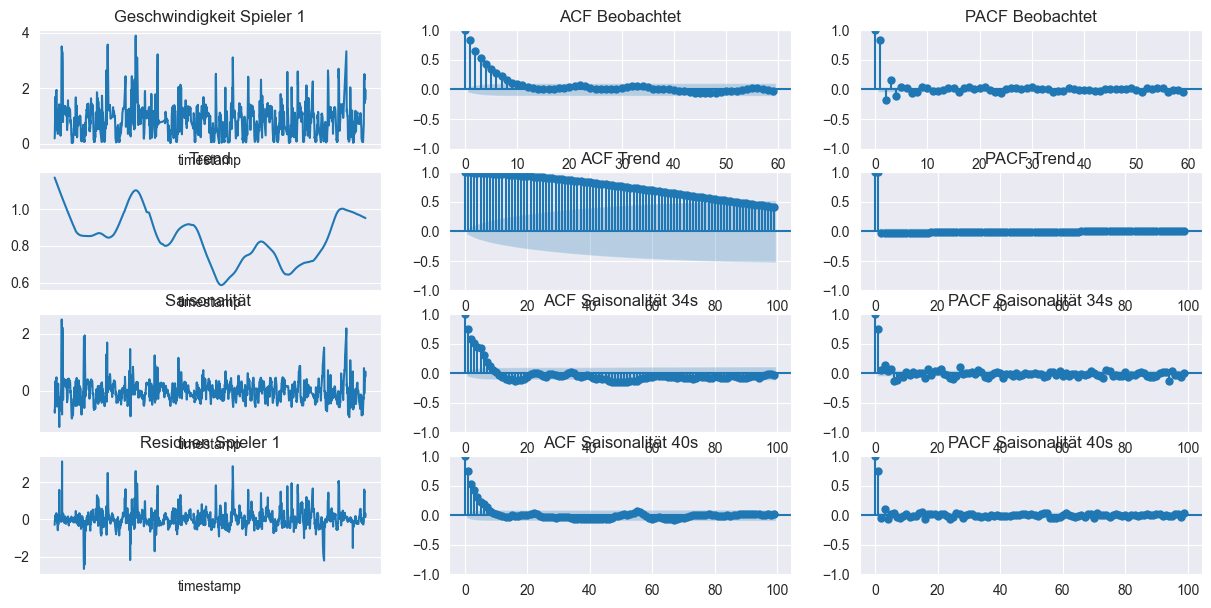

In [398]:
fig, axes = plt.subplots(4, 3, figsize=(15, 8))

# Beobachtete Daten
model_p1.observed.plot(ax=axes[0, 0], title="Geschwindigkeit Spieler 1")
axes[0, 0].set_xticks([])
plot_acf(model_p1.observed, ax=axes[0, 1], title="ACF Beobachtet", lags= range(0,60))
plot_pacf(model_p1.observed, ax=axes[0, 2], title="PACF Beobachtet", lags= range(0,60))

# Trend
model_p1.trend.plot(ax=axes[1, 0], title="Trend")
axes[1, 0].set_xticks([])
plot_acf(model_p1.trend, ax=axes[1, 1], title="ACF Trend", lags= range(0,100))
plot_pacf(model_p1.trend, ax=axes[1, 2], title="PACF Trend", lags= range(0,100))

# Saisonale Komponente
model_p1.seasonal.plot(ax=axes[2, 0], title="Saisonalität ")
axes[2, 0].set_xticks([])
plot_acf(model_p1.seasonal, ax=axes[2, 1], title="ACF Saisonalität 34s", lags= range(0,100))
plot_pacf(model_p1.seasonal, ax=axes[2, 2], title="PACF Saisonalität 34s", lags= range(0,100))

model_p1.resid.plot(ax=axes[3, 0], title="Residuen Spieler 1")
axes[3, 0].set_xticks([])
plot_acf(model_p1.resid, ax=axes[3, 1], title="ACF Saisonalität 40s", lags= range(0,100))
plot_pacf(model_p1.resid, ax=axes[3, 2], title="PACF Saisonalität 40s", lags= range(0,100))
plt.show()

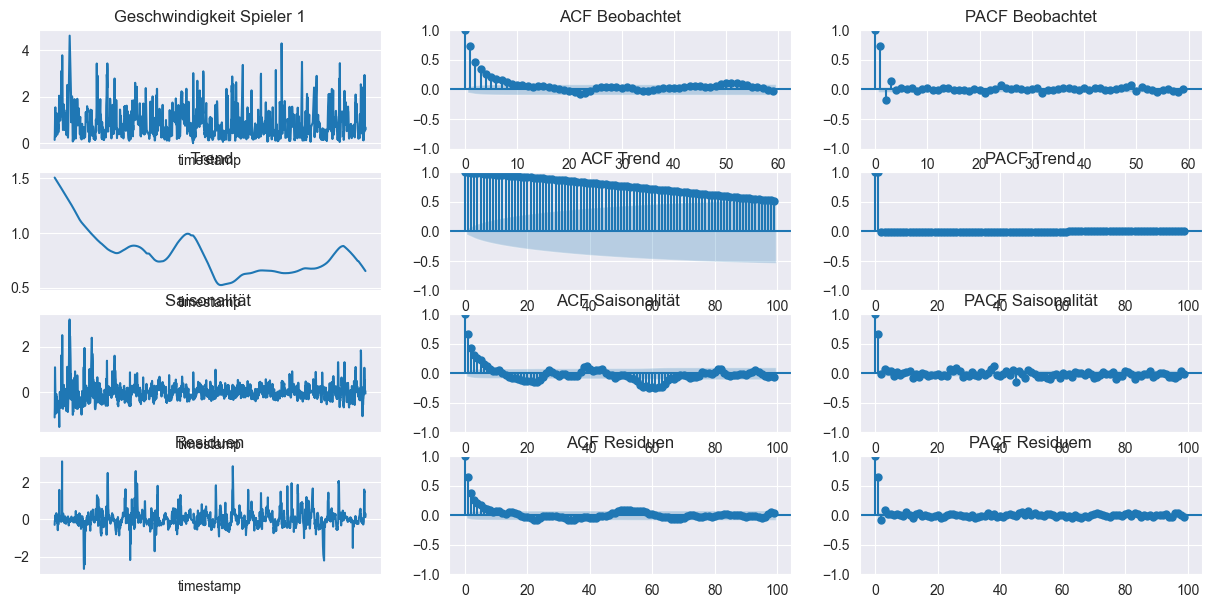

In [399]:
model_p2 = STL(data_s["geschwindigkeit_p2_k_ip"],period=60*2,robust=True).fit()
fig, axes = plt.subplots(4, 3, figsize=(15, 8))

# Beobachtete Daten
model_p2.observed.plot(ax=axes[0, 0], title="Geschwindigkeit Spieler 1")
axes[0, 0].set_xticks([])
plot_acf(model_p2.observed, ax=axes[0, 1], title="ACF Beobachtet", lags= range(0,60))
plot_pacf(model_p2.observed, ax=axes[0, 2], title="PACF Beobachtet", lags= range(0,60))

# Trend
model_p2.trend.plot(ax=axes[1, 0], title=" Trend")
axes[1, 0].set_xticks([])
plot_acf(model_p2.trend, ax=axes[1, 1], title="ACF Trend", lags= range(0,100))
plot_pacf(model_p2.trend, ax=axes[1, 2], title="PACF Trend", lags= range(0,100))

# Saisonale Komponente
model_p2.seasonal.plot(ax=axes[2, 0], title="Saisonalität ")
axes[2, 0].set_xticks([])
plot_acf(model_p2.seasonal, ax=axes[2, 1], title="ACF Saisonalität ", lags= range(0,100))
plot_pacf(model_p2.seasonal, ax=axes[2, 2], title="PACF Saisonalität", lags= range(0,100))

model_p1.resid.plot(ax=axes[3, 0], title="Residuen")
axes[3, 0].set_xticks([])
plot_acf(model_p2.resid, ax=axes[3, 1], title="ACF Residuen", lags= range(0,100))
plot_pacf(model_p2.resid, ax=axes[3, 2], title="PACF Residuem", lags= range(0,100))
plt.show()

In [400]:
fig, axes = plt.subplots(4, 3, figsize=(15, 8))

# Beobachtete Daten
model_p1.observed.plot(ax=axes[0, 0], title="Geschwindigkeit Spieler 1")
axes[0, 0].set_xticks([])
plot_acf(model_p1.observed, ax=axes[0, 1], title="ACF Beobachtet", lags= range(0,60))
plot_pacf(model_p1.observed, ax=axes[0, 2], title="PACF Beobachtet", lags= range(0,60))

# Trend
model_p1.trend.plot(ax=axes[1, 0], title="Trend")
axes[1, 0].set_xticks([])
plot_acf(model_p1.trend, ax=axes[1, 1], title="ACF Trend", lags= range(0,100))
plot_pacf(model_p1.trend, ax=axes[1, 2], title="PACF Trend", lags= range(0,100))

# Saisonale Komponente
model_p1.seasonal.plot(ax=axes[2, 0], title="Saisonalität ")
axes[2, 0].set_xticks([])
plot_acf(model_p1.seasonal, ax=axes[2, 1], title="ACF Saisonalität 34s", lags= range(0,100))
plot_pacf(model_p1.seasonal, ax=axes[2, 2], title="PACF Saisonalität 34s", lags= range(0,100))

model_p1.resid.plot(ax=axes[3, 0], title="Residuen Spieler 1")
axes[3, 0].set_xticks([])
plot_acf(model_p1.resid, ax=axes[3, 1], title="ACF Saisonalität 40s", lags= range(0,100))
plot_pacf(model_p1.resid, ax=axes[3, 2], title="PACF Saisonalität 40s", lags= range(0,100))
plt.show()

SyntaxError: invalid syntax (946144210.py, line 1)

In [ ]:
model_p2 = STL(data_s["geschwindigkeit_p2_k_ip"],period=60*2,robust=True).fit()
fig, axes = plt.subplots(4, 3, figsize=(15, 8))

# Beobachtete Daten
model_p2.observed.plot(ax=axes[0, 0], title="Geschwindigkeit Spieler 1")
axes[0, 0].set_xticks([])
plot_acf(model_p2.observed, ax=axes[0, 1], title="ACF Beobachtet", lags= range(0,60))
plot_pacf(model_p2.observed, ax=axes[0, 2], title="PACF Beobachtet", lags= range(0,60))

# Trend
model_p2.trend.plot(ax=axes[1, 0], title=" Trend")
axes[1, 0].set_xticks([])
plot_acf(model_p2.trend, ax=axes[1, 1], title="ACF Trend", lags= range(0,100))
plot_pacf(model_p2.trend, ax=axes[1, 2], title="PACF Trend", lags= range(0,100))

# Saisonale Komponente
model_p2.seasonal.plot(ax=axes[2, 0], title="Saisonalität ")
axes[2, 0].set_xticks([])
plot_acf(model_p2.seasonal, ax=axes[2, 1], title="ACF Saisonalität ", lags= range(0,100))
plot_pacf(model_p2.seasonal, ax=axes[2, 2], title="PACF Saisonalität", lags= range(0,100))

model_p1.resid.plot(ax=axes[3, 0], title="Residuen")
axes[3, 0].set_xticks([])
plot_acf(model_p2.resid, ax=axes[3, 1], title="ACF Residuen", lags= range(0,100))
plot_pacf(model_p2.resid, ax=axes[3, 2], title="PACF Residuem", lags= range(0,100))
plt.show()

In [403]:
result = adfuller(model_p2.resid)

# Extrahiere die Teststatistik und den p-Wert aus dem Ergebnis
test_statistic = result[0]
p_value = result[1]

# Definiere das Signifikanzniveau
significance_level = 0.05

# Vergleiche den p-Wert mit dem Signifikanzniveau
if p_value < significance_level:
    print("Die Residuen sind stationär.")
else:
    print("Die Residuen sind nicht stationär.")

Die Residuen sind stationär.


Die Zerlegung in den einzelnen Komponenten erstellte sich als schwiereiger, da es ziemlich doch ziemlich viele wiederholende

#### Kreuzkorrelation

In [ ]:
residuen_p1 = model_p1.resid.dropna()
residuen_p2 = model_p2.resid.dropna()

# Kreuzkorrelation plotten
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Kreuzkorrelation 50 lags
lags_1, c_1, line_1, b_1 = ax1.xcorr(residuen_p1, residuen_p2, usevlines=True,
           maxlags=20, normed=True, lw=2)
ax1.set_title("Kreuzkorrelation 50 lags")
ax1.set_xlabel("Lag (0.5s)")
ax1.set_xticks(range(-20,21,1))
ax1.grid(True)

# Kreuzkorrelation 300 lags
lags_2, c_2, line_2, b_2 = ax2.xcorr( residuen_p1,residuen_p2, usevlines=True,                                     maxlags=300, normed=True, lw=2)
ax2.set_title("Kreuzkorrelation 30 lags")
ax2.set_xlabel("Lag (0.5s)")
ax2.set_xticks(range(-300,301,20))
ax2.grid(True)

plt.suptitle("Kreuzkorrelation zwischen den Residuen vom Spieler 1 und Spieler 2")
plt.tight_layout()
plt.show()

In [ ]:
data.head()

In [ ]:
data_hmm = data[['geschwindigkeit_p1_k_ip','geschwindigkeit_p2_k_ip', 'new_x_Player1','new_y_Player1','new_z_Player1','width_Player1',
'Schlag_p1','Schlag_p2','s','Status','frame','vx_Player1','vz_Player1']]
data_hmm['ges_xz'] = np.sqrt((data_hmm['vx_Player1']**2) + (data_hmm['vz_Player1']**2))
data_hmm = data_hmm.drop(['vx_Player1','vz_Player1'],axis=1)

schlag_dummies = pd.get_dummies(data_hmm['Schlag_p1'], prefix='P1', dummy_na=True)
data_hmm = pd.concat([data_hmm, schlag_dummies], axis=1)

schlag_dummies = pd.get_dummies(data_hmm['Schlag_p2'],prefix= 'P2')
data_hmm = pd.concat([data_hmm, schlag_dummies], axis=1)
status_dummies = pd.get_dummies(data_hmm['Status'])
data_hmm = pd.concat([data_hmm, status_dummies], axis=1)

bool_columns = data_hmm.select_dtypes(include='bool').columns
data_hmm[bool_columns] = data_hmm[bool_columns].astype(int)
data_hmm.drop(['Schlag_p1', 'Schlag_p2', 'Status', 'P1_nan', 'Aktiv'], axis=1, inplace=True)
data_hmm['p1_besch'] = data_hmm['geschwindigkeit_p1_k_ip'].diff()
data_hmm['ges_xz'] = np.sqrt((data_hmm['new_x_Player1']**2) + (data_hmm['new_y_Player1']**2))
data_hmm= data_hmm.dropna()

In [ ]:
features = ['p1_besch', 'geschwindigkeit_p1_k_ip']
data_hmm = data_hmm.dropna()
X = data_hmm[features].values

In [ ]:
model_pg = hmm.GaussianHMM(n_components=3, n_iter=100, random_state = 1)

# Trainieren des Modells mit den Daten
model_pg.fit(X)
# Vorhersagen der versteckten Zustände (Cluster)
hidden_states = model_pg.predict(X)
data_hmm['hidden_state_pg'] = hidden_states

In [ ]:
unique_states = data_hmm['hidden_state_pg'].unique()
for state in reversed(unique_states):
    if state == 0:
        alp = 1
    else:
        alp = 0.1
    subset = data_hmm[data_hmm['hidden_state_pg'] == state]
    plt.scatter(subset['geschwindigkeit_p1_k_ip'],subset['p1_besch'],  label=f'State {state}', alpha= alp)

plt.xlabel('Geschwindigkeit')
plt.ylabel('Beschleunigung')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
data_hmm['state_change_pg'] = (data_hmm['hidden_state_pg'].diff() != 0).astype(int)
data_hmm

In [ ]:
model = hmm.GaussianHMM(n_components=5, n_iter=100)

# Trainieren des Modells mit den Daten
model.fit(X)

# Vorhersagen der versteckten Zustände (Cluster)
hidden_states = model.predict(X)

# Hinzufügen der vorhergesagten Zustände zu den originalen Daten
data_hmm['hidden_state'] = hidden_states

unique_states = data_hmm['hidden_state'].unique()
funique_states = data_hmm['hidden_state'].unique()

# Number of rows and columns for subplots
n_rows = 3
n_cols = 2

# Create a figure and set of subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))
fig.tight_layout(pad=3.0)

# Adjust for the case of a single subplot
if len(unique_states) == 1:
    axs = [axs]

# Flatten the axis array for easy indexing
axs = axs.flatten()

for idx, state in enumerate(unique_states):
    subset = data_hmm[data_hmm['hidden_state'] == state]
    axs[idx].scatter(subset['geschwindigkeit_p1_k_ip'], subset['p1_besch'], label=f'State {state}', alpha=0.1)
    axs[idx].set_xlabel('Geschwindigkeit')
    axs[idx].set_ylabel('Beschleunigung')
    axs[idx].legend()
    axs[idx].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for ax in axs[len(unique_states):]:
    ax.set_visible(False)

### Zusammenfassung